In [1]:
import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

import cPickle as pkl
from scipy import stats as spstats

from pipeline.python.classifications import responsivity_stats as resp
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import get_dataset_stats as ds
from pipeline.python.utils import natural_keys, label_figure, convert_range

from pipeline.python.retinotopy import convert_coords as cc


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app

In [2]:
%matplotlib notebook

# Set output dir


In [3]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set dataset parameters

In [7]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
response_type = 'dff'
traceid='traces001'
trace_type= 'corrected'
responsive_test = 'ROC'
fit_thr=0.5

In [8]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print(fit_desc)

data_desc = '-'.join([traceid, trace_type, response_type, responsive_test])

data_identifier = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print(data_identifier)

fit-2dgaus_dff-no-cutoff
traces001-corrected-dff-ROC|fit-2dgaus_dff-no-cutoff-thr-0.50


# Create output dir for specified RF fits

In [9]:
rfdir = os.path.join(aggregate_dir, 'rfs', fit_desc)
if not os.path.exists(rfdir):
    os.makedirs(rfdir)

# Get summary of all datasets

In [10]:
dataset_info_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(dataset_info_fpath):
    with open(dataset_info_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = ds.aggregate_session_info()

In [11]:
sdata.head()

animalid experiment            fov   session visual_area  exp_no  animal_no
0    JC084        rfs  FOV1_zoom2p0x  20190522          V1       3          4
1    JC084   gratings  FOV1_zoom2p0x  20190522          V1       1          4
2    JC084      blobs  FOV1_zoom2p0x  20190522          V1       0          4
3    JC084     retino  FOV1_zoom2p0x  20190522          V1       2          4
4    JC084        rfs  FOV1_zoom2p0x  20190525          Lm       3          4

In [12]:
sdata['experiment'].unique()

array(['rfs', 'gratings', 'blobs', 'retino', 'rfs10'], dtype=object)

# Select datasets - no reps

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [13]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']

also_exclude = ['JC083-20190511',
                'JC078-2019513', 'JC083-20190512']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

13


In [15]:
excluded_sessions

['JC076-20190501',
 'JC083-20190510',
 'JC078-20190426',
 'JC078-20190509',
 'JC080-20190506',
 'JC083-20190517',
 'JC076-20190422',
 'JC099-20190509',
 'JC091-20190607',
 'JC091-20190606',
 'JC083-20190511',
 'JC078-2019513',
 'JC083-20190512']

In [16]:
rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
print rfdata.shape
for skey in excluded_sessions:
    animalid, session = skey.split('-')
    drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
    rfdata = rfdata.drop(drop_ixs)
print rfdata.shape

(40, 7)
(30, 7)


In [17]:
rfdata

animalid experiment            fov   session visual_area  exp_no  \
0      JC084        rfs  FOV1_zoom2p0x  20190522          V1       3   
4      JC084        rfs  FOV1_zoom2p0x  20190525          Lm       3   
8      JC091        rfs  FOV1_zoom2p0x  20190627          Lm       3   
16     JC091      rfs10  FOV1_zoom2p0x  20190614          Li       4   
24     JC091        rfs  FOV1_zoom2p0x  20190602          Li       3   
25     JC091      rfs10  FOV1_zoom2p0x  20190602          Li       4   
29     JC085        rfs  FOV1_zoom2p0x  20190622          V1       3   
30     JC085      rfs10  FOV1_zoom2p0x  20190622          V1       4   
34     JC090      rfs10  FOV1_zoom2p0x  20190605          Li       4   
38     JC099      rfs10  FOV1_zoom2p0x  20190612          Li       4   
42     JC099      rfs10  FOV1_zoom2p0x  20190617          Li       4   
46     JC099      rfs10  FOV1_zoom2p0x  20190609          Li       4   
50     JC097      rfs10  FOV1_zoom2p0x  20190615          V1       4   
52     JC097      rfs10  FOV2_zoom2p0x  20190615          V1       4   
53     JC097        rfs  FOV1_zoom2p0x  20190617          V1       3   
57     JC097        rfs  FOV1_zoom2p0x  20190616          V1       3   
58     JC097      rfs10  FOV1_zoom2p0x  20190616          V1       4   
62     JC097        rfs  FOV1_zoom2p0x  20190613          V1       3   
63     JC097      rfs10  FOV1_zoom2p0x  20190613          V1       4   
69     JC076        rfs  FOV1_zoom2p0x  20190420          V1       3   
74     JC076        rfs  FOV1_zoom2p0x  20190423          Lm       3   
76     JC076        rfs  FOV1_zoom2p0x  20190502          Li       3   
81     JC078        rfs  FOV1_zoom2p0x  20190504          Lm       3   
84     JC078        rfs  FOV1_zoom2p0x  20190430          Lm       3   
88     JC078        rfs  FOV1_zoom2p0x  20190513          Lm       3   
95     JC080        rfs  FOV1_zoom2p0x  20190603          Lm       3   
103    JC080      rfs10  FOV2_zoom2p0x  20190602          Lm       4   
105    JC080      rfs10  FOV1_zoom2p0x  20190602          Li       4   
111    JC083        rfs  FOV1_zoom2p0x  20190507          V1       3   
126    JC083        rfs  FOV1_zoom2p0x  20190508          Lm       3   

     animal_no  
0            4  
4            4  
8            7  
16           7  
24           7  
25           7  
29           5  
30           5  
34           6  
38           9  
42           9  
46           9  
50           8  
52           8  
53           8  
57           8  
58           8  
62           8  
63           8  
69           0  
74           0  
76           0  
81           1  
84           1  
88           1  
95           2  
103          2  
105          2  
111          3  
126          3

# Check for any datasets that need RF fits

In [18]:
def get_rfdata(sdata, fit_desc=None, excluded_sessions=[]):
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
    for skey in excluded_sessions:
        animalid, session = skey.split('-')
        drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
        rfdata= rfdata.drop(drop_ixs)
            
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '-'.join([animalid, session])
        if skey in excluded_sessions:
            continue

        rfruns = g['experiment'].unique()

        for rfname in rfruns:
            if int(session) < 20190511:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_gratings*', 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            else:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_%s_*' % rfname, 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "TOo many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
                
            elif len(f) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                unknown.append((animalid, session, fov, rfname))
    nostats = []
    for (animalid, session, fov, run_name) in fit_these:
        nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

    
    print ("N dpaths: %i, N unfit: %i, N unknown: %i" % (len(dpaths), len(fit_these), len(unknown)))
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    #assert (len(dpaths) + len(fit_these) + len(unknown)) == rfdata.shape[0] - len(excluded_sessions), "There are dsets unaccounted for..."
    
    rfdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rfdata[ (rfdata['animalid']==animalid) \
                           & (rfdata['session']==session) \
                           & (rfdata['fov']==fov) \
                           & (rfdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rfdata['path'] = fillpaths
    
    return rfdata, nostats

In [19]:
exclude_repeats=True
if exclude_repeats:
    rfdata, nostats = get_rfdata(sdata, fit_desc=fit_desc, excluded_sessions=excluded_sessions)
else:
    rfdata, nostats = get_rfdata(sdata, fit_desc=fit_desc, excluded_sessions=[])
    print(nostats)

N dpaths: 30, N unfit: 0, N unknown: 0
N datasets included: 30, N sessions excluded: 13


# Get RF dataframe for all datasets

In [ ]:
tmp_exclude = ['JC076-20190502', 'JC091-20190602', '']

In [20]:
rfdata

index animalid experiment            fov   session visual_area  exp_no  \
0       0    JC084        rfs  FOV1_zoom2p0x  20190522          V1       3   
1       4    JC084        rfs  FOV1_zoom2p0x  20190525          Lm       3   
2       8    JC091        rfs  FOV1_zoom2p0x  20190627          Lm       3   
3      16    JC091      rfs10  FOV1_zoom2p0x  20190614          Li       4   
4      24    JC091        rfs  FOV1_zoom2p0x  20190602          Li       3   
5      25    JC091      rfs10  FOV1_zoom2p0x  20190602          Li       4   
6      29    JC085        rfs  FOV1_zoom2p0x  20190622          V1       3   
7      30    JC085      rfs10  FOV1_zoom2p0x  20190622          V1       4   
8      34    JC090      rfs10  FOV1_zoom2p0x  20190605          Li       4   
9      38    JC099      rfs10  FOV1_zoom2p0x  20190612          Li       4   
10     42    JC099      rfs10  FOV1_zoom2p0x  20190617          Li       4   
11     46    JC099      rfs10  FOV1_zoom2p0x  20190609          Li       4   
12     50    JC097      rfs10  FOV1_zoom2p0x  20190615          V1       4   
13     52    JC097      rfs10  FOV2_zoom2p0x  20190615          V1       4   
14     53    JC097        rfs  FOV1_zoom2p0x  20190617          V1       3   
15     57    JC097        rfs  FOV1_zoom2p0x  20190616          V1       3   
16     58    JC097      rfs10  FOV1_zoom2p0x  20190616          V1       4   
17     62    JC097        rfs  FOV1_zoom2p0x  20190613          V1       3   
18     63    JC097      rfs10  FOV1_zoom2p0x  20190613          V1       4   
19     69    JC076        rfs  FOV1_zoom2p0x  20190420          V1       3   
20     74    JC076        rfs  FOV1_zoom2p0x  20190423          Lm       3   
21     76    JC076        rfs  FOV1_zoom2p0x  20190502          Li       3   
22     81    JC078        rfs  FOV1_zoom2p0x  20190504          Lm       3   
23     84    JC078        rfs  FOV1_zoom2p0x  20190430          Lm       3   
24     88    JC078        rfs  FOV1_zoom2p0x  20190513          Lm       3   
25     95    JC080        rfs  FOV1_zoom2p0x  20190603          Lm       3   
26    103    JC080      rfs10  FOV2_zoom2p0x  20190602          Lm       4   
27    105    JC080      rfs10  FOV1_zoom2p0x  20190602          Li       4   
28    111    JC083        rfs  FOV1_zoom2p0x  20190507          V1       3   
29    126    JC083        rfs  FOV1_zoom2p0x  20190508          Lm       3   

    animal_no                                               path  
0           4  /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0...  
1           4  /n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0...  
2           7  /n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0...  
3           7  /n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0...  
4           7  /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0...  
5           7  /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0...  
6           5  /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0...  
7           5  /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0...  
8           6  /n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0...  
9           9  /n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0...  
10          9  /n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0...  
11          9  /n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0...  
12          8  /n/coxfs01/2p-data/JC097/20190615/FOV1_zoom2p0...  
13          8  /n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0...  
14          8  /n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0...  
15          8  /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0...  
16          8  /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0...  
17          8  /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0...  
18          8  /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0...  
19          0  /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...  
20          0  /n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0...  
21          0  /n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0...  
22          1  /n/coxfs01/2p-data/JC078/2019

In [21]:
def aggregate_rf_data(rfdata, fit_thr=0.5, sigma_scale=2.35):
    df_list = []

    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
        skey = '-'.join([animalid, session, fov])
        rfruns = g['experiment'].unique()
        print ("%s - %s: %i rf experiments." % (visual_area, skey, len(rfruns)))
        if 'rfs10' in rfruns:
            rfname = 'rfs10'
        else:
            rfname = 'rfs'
        fpath = g[g['experiment']==rfname]['path'].values[0]

        with open(fpath,'rb') as f:
            rfits = pkl.load(f)

        roi_list = [r for r, res in rfits['fit_results'].items() if res['fit_r']['r2'] >= fit_thr]
        fitdf = fitrf.rfits_to_df(rfits['fit_results'], 
                                row_vals=rfits['row_vals'],
                                col_vals=rfits['col_vals'],
                                roi_list=sorted(roi_list))
        nsamples = fitdf.shape[0]
        fitdf['cell'] = [int(i) for i in fitdf.index.tolist()]
        fitdf['animalid'] = [animalid for _ in range(nsamples)]
        fitdf['session'] = [session for _ in range(nsamples)]
        fitdf['visual_area'] = [visual_area for _ in range(nsamples)]
        fitdf['fov'] = [fov for _ in range(nsamples)]

        df_list.append(fitdf)

    rfdf = pd.concat(df_list, axis=0) #.reset_index(drop=True)
    
    # Update sigma to reflect FWHM
    rfdf['sigma_x'] = rfdf['sigma_x']*sigma_scale
    rfdf['sigma_y'] = rfdf['sigma_y']*sigma_scale
    rfdf['avg_size'] = rfdf[['sigma_x', 'sigma_y']].mean(axis=1)

    return rfdf

In [22]:
fit_thr = 0.5
sigma_scale = 2.35

rfdf = aggregate_rf_data(rfdata, fit_thr=fit_thr, sigma_scale=sigma_scale)


Li - JC076-20190502-FOV1_zoom2p0x: 1 rf experiments.
Li - JC080-20190602-FOV1_zoom2p0x: 1 rf experiments.
Li - JC090-20190605-FOV1_zoom2p0x: 1 rf experiments.
Li - JC091-20190602-FOV1_zoom2p0x: 2 rf experiments.
Li - JC091-20190614-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190609-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190612-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190617-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC076-20190423-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190430-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190504-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190513-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC080-20190602-FOV2_zoom2p0x: 1 rf experiments.
Lm - JC080-20190603-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC083-20190508-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC084-20190525-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC091-20190627-FOV1_zoom2p0x: 1 rf experiments.
V1 - JC076-20190420-FOV1_zoom2p0x: 1 rf experiments.
V1 - JC083-20190507-FOV1_zoom2p0x: 1 rf experi

In [23]:
rfdf

r2    sigma_x    sigma_y      theta         x0         y0   cell  \
0    0.814382  23.146798  13.394771   0.131838   6.947459  -8.639012    0.0   
7    0.684173  37.878427  29.035087  -0.425973 -29.804538  -2.607508    7.0   
11   0.547915  42.869814  25.073697  -3.139462 -25.042646   0.492693   11.0   
84   0.694613  41.777743  27.529382   0.277368 -23.260081  -2.007161   84.0   
107  0.553680  23.755476  17.985994   1.224352  -1.715291  15.132260  107.0   
114  0.555700  49.130250  21.382432   3.662978  -0.701245  23.751010  114.0   
120  0.798962  23.080949  49.025305   0.089750   2.689807  47.478206  120.0   
135  0.608521  26.647765  30.661356   1.342867   0.310076  18.084239  135.0   
143  0.612314  15.865567  12.826058   0.601666  -4.026763  23.330451  143.0   
169  0.828918  26.503840  44.212059  -1.521403  -5.222194  19.280016  169.0   
176  0.843961  43.150626  27.841477   0.264600  25.389084  20.691260  176.0   
177  0.662841  33.006514  20.963053   0.457506  24.046525  21.383867  177.0   
179  0.842919  41.765323  22.819800  -0.253802  28.173561   4.237325  179.0   
181  0.707526  38.709151  16.078422  -0.089576  24.729406   0.268811  181.0   
185  0.556624  17.776519  14.451808   2.402928   2.843616   5.380603  185.0   
186  0.570382  24.407816  14.977647   0.001726  -0.436501   8.922238  186.0   
187  0.827063  13.998498  21.809675   1.911800  -4.948713  10.120009  187.0   
192  0.711208  23.672857  34.625232  67.847659  -0.997297   6.944240  192.0   
196  0.710367  36.290168  22.694504  -0.029234 -10.234178  11.455400  196.0   
202  0.750970  19.067069  13.932038   0.204301  -3.027946   8.827586  202.0   
213  0.609544  31.595342  17.056111   0.066402   5.925531   6.758347  213.0   
13   0.887474  37.221695  28.540487  -0.351618  42.845557  11.099507   13.0   
17   0.794474  46.847062  22.845960   0.430578  40.974501  -4.848884   17.0   
53   0.560526  43.327534  32.714285   2.946825  40.867527  -6.879681   53.0   
59   0.535501  28.720887  15.557808   0.254644  23.164614 -11.713391   59.0   
140  0.745079  43.595926  35.102888  -2.542915  35.023622 -11.230811  140.0   
141  0.781449  44.527242  28.168399  -0.145137  43.588204 -14.186040  141.0   
148  0.767372  48.079083  34.807038   0.023057  33.038340 -16.059210  148.0   
165  0.894280  29.334396  24.191826   0.279342  41.339426 -18.524163  165.0   
166  0.580755  31.498189  16.627704  -0.025839  41.892471 -16.233362  166.0   
..        ...        ...        ...        ...        ...        ...    ...   
228  0.589609  23.620831  12.633704  -0.118943  29.680401   2.128498  228.0   
230  0.628138  14.819839  13.192887   2.589669  29.462237   2.069102  230.0   
233  0.610853  19.273806  12.380906  -0.007399  42.197621  -2.721178  233.0   
234  0.669391  21.747245  16.242798  -0.169227  28.251771   0.100650  234.0   
247  0.562274  29.153524  18.641860   0.121678  30.875839   0.178373  247.0   
249  0.739928  25.651451  15.067962  -0.049578  31.636395  -1.388606  249.0   
277  0.703708  19.486284  25.567114  -0.833242  27.527124  -5.588575  277.0   
279  0.575775  25.911791  21.124656   0.730177  31.339668  -2.003794  279.0   
288  0.655451  12.519577   8.875096   1.279860  26.859476  -5.219653  288.0   
292  0.601633  21.248889  15.267881  -0.231806  26.618432  -6.255179  292.0   
298  0.524361  28.658660  13.550217   0.363848  29.662592  -3.111209  298.0   
302  0.656535  20.002383  12.321070   0.179928  20.991807  -6.901376  302.0   
306  0.669690  11.373147   9.207166  -0.214191  20.626606  -9.055759  306.0   
310  0.504045  21.177471  16.489039   0.217502  19.626858  -6.463010  310.0   
312  0.537231  18.275604   9.659477  -0.020433  17.264125  -8.913125  312.0   
314  0.513204  13.356591  19.447269  -1.365487  20.885766  -6.576282  314.0   
339  0.723463  15.857012  18.477368   0.733938  19.239861  -9.678256  339.0   
361  0.545847  17.563339  14.589665  -0.147211  27.871401  -3.876638  361.0   
367  0.830982  14.357517   9.195118   0.054904  28.857671  -8

In [24]:
rfdf.shape

(1562, 12)

<IPython.core.display.Javascript object>


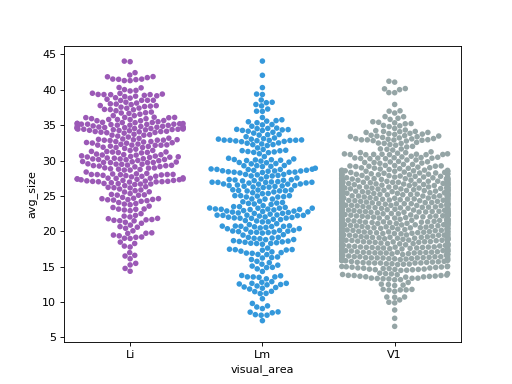

In [25]:
pl.figure()
sns.swarmplot(x="visual_area", y="avg_size", data=rfdf)

In [26]:
sorted(excluded_sessions, key=natural_keys)

['JC076-20190422',
 'JC076-20190501',
 'JC078-2019513',
 'JC078-20190426',
 'JC078-20190509',
 'JC080-20190506',
 'JC083-20190510',
 'JC083-20190511',
 'JC083-20190512',
 'JC083-20190517',
 'JC091-20190606',
 'JC091-20190607',
 'JC099-20190509']

In [27]:
rfdf

r2    sigma_x    sigma_y      theta         x0         y0   cell  \
0    0.814382  23.146798  13.394771   0.131838   6.947459  -8.639012    0.0   
7    0.684173  37.878427  29.035087  -0.425973 -29.804538  -2.607508    7.0   
11   0.547915  42.869814  25.073697  -3.139462 -25.042646   0.492693   11.0   
84   0.694613  41.777743  27.529382   0.277368 -23.260081  -2.007161   84.0   
107  0.553680  23.755476  17.985994   1.224352  -1.715291  15.132260  107.0   
114  0.555700  49.130250  21.382432   3.662978  -0.701245  23.751010  114.0   
120  0.798962  23.080949  49.025305   0.089750   2.689807  47.478206  120.0   
135  0.608521  26.647765  30.661356   1.342867   0.310076  18.084239  135.0   
143  0.612314  15.865567  12.826058   0.601666  -4.026763  23.330451  143.0   
169  0.828918  26.503840  44.212059  -1.521403  -5.222194  19.280016  169.0   
176  0.843961  43.150626  27.841477   0.264600  25.389084  20.691260  176.0   
177  0.662841  33.006514  20.963053   0.457506  24.046525  21.383867  177.0   
179  0.842919  41.765323  22.819800  -0.253802  28.173561   4.237325  179.0   
181  0.707526  38.709151  16.078422  -0.089576  24.729406   0.268811  181.0   
185  0.556624  17.776519  14.451808   2.402928   2.843616   5.380603  185.0   
186  0.570382  24.407816  14.977647   0.001726  -0.436501   8.922238  186.0   
187  0.827063  13.998498  21.809675   1.911800  -4.948713  10.120009  187.0   
192  0.711208  23.672857  34.625232  67.847659  -0.997297   6.944240  192.0   
196  0.710367  36.290168  22.694504  -0.029234 -10.234178  11.455400  196.0   
202  0.750970  19.067069  13.932038   0.204301  -3.027946   8.827586  202.0   
213  0.609544  31.595342  17.056111   0.066402   5.925531   6.758347  213.0   
13   0.887474  37.221695  28.540487  -0.351618  42.845557  11.099507   13.0   
17   0.794474  46.847062  22.845960   0.430578  40.974501  -4.848884   17.0   
53   0.560526  43.327534  32.714285   2.946825  40.867527  -6.879681   53.0   
59   0.535501  28.720887  15.557808   0.254644  23.164614 -11.713391   59.0   
140  0.745079  43.595926  35.102888  -2.542915  35.023622 -11.230811  140.0   
141  0.781449  44.527242  28.168399  -0.145137  43.588204 -14.186040  141.0   
148  0.767372  48.079083  34.807038   0.023057  33.038340 -16.059210  148.0   
165  0.894280  29.334396  24.191826   0.279342  41.339426 -18.524163  165.0   
166  0.580755  31.498189  16.627704  -0.025839  41.892471 -16.233362  166.0   
..        ...        ...        ...        ...        ...        ...    ...   
228  0.589609  23.620831  12.633704  -0.118943  29.680401   2.128498  228.0   
230  0.628138  14.819839  13.192887   2.589669  29.462237   2.069102  230.0   
233  0.610853  19.273806  12.380906  -0.007399  42.197621  -2.721178  233.0   
234  0.669391  21.747245  16.242798  -0.169227  28.251771   0.100650  234.0   
247  0.562274  29.153524  18.641860   0.121678  30.875839   0.178373  247.0   
249  0.739928  25.651451  15.067962  -0.049578  31.636395  -1.388606  249.0   
277  0.703708  19.486284  25.567114  -0.833242  27.527124  -5.588575  277.0   
279  0.575775  25.911791  21.124656   0.730177  31.339668  -2.003794  279.0   
288  0.655451  12.519577   8.875096   1.279860  26.859476  -5.219653  288.0   
292  0.601633  21.248889  15.267881  -0.231806  26.618432  -6.255179  292.0   
298  0.524361  28.658660  13.550217   0.363848  29.662592  -3.111209  298.0   
302  0.656535  20.002383  12.321070   0.179928  20.991807  -6.901376  302.0   
306  0.669690  11.373147   9.207166  -0.214191  20.626606  -9.055759  306.0   
310  0.504045  21.177471  16.489039   0.217502  19.626858  -6.463010  310.0   
312  0.537231  18.275604   9.659477  -0.020433  17.264125  -8.913125  312.0   
314  0.513204  13.356591  19.447269  -1.365487  20.885766  -6.576282  314.0   
339  0.723463  15.857012  18.477368   0.733938  19.239861  -9.678256  339.0   
361  0.545847  17.563339  14.589665  -0.147211  27.871401  -3.876638  361.0   
367  0.830982  14.357517   9.195118   0.054904  28.857671  -8

In [28]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x     90
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190513  FOV1_zoom2p0x     23
             JC080     20190602  FOV2_zoom2p0x     36
                       20190603  FOV1_zoom2p0x     58
             JC083     20190508  FOV1_zoom2p0x     70
             JC084     20190525  FOV1_zoom2p0x     42
             JC091     20190627  FOV1_zoom2p0x     12
V1           JC076     20190420  FOV1_zoom2p0x     48
             JC083     20190507  FO

In [29]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x     90
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190513  FOV1_zoom2p0x     23
             JC080     20190602  FOV2_zoom2p0x     36
                       20190603  FOV1_zoom2p0x     58
             JC083     20190508  FOV1_zoom2p0x     70
             JC084     20190525  FOV1_zoom2p0x     42
             JC091     20190627  FOV1_zoom2p0x     12
V1           JC076     20190420  FOV1_zoom2p0x     48
             JC083     20190507  FO

In [183]:
rfdf.groupby(['visual_area'])['cell'].count()

visual_area
Li    333
Lm    317
V1    912
Name: cell, dtype: int64

In [26]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x    138
                       20190606  FOV1_zoom2p0x     48
                       20190607  FOV1_zoom2p0x     73
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190426  FOV1_zoom2p0x     91
                       20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190509  FOV1_zoom2p0x     14
                       20190513  FOV1_zoom2p0x     23
             JC080     20190506  FOV1_zoom2p0x     31
                       20190602  FOV2_zoom2p0x     36
                       20190603  FO

In [34]:
rfdf.groupby(['visual_area', 'animalid', 'session'])['cell'].count()

visual_area  animalid  session 
Li           JC076     20190502     21
             JC090     20190605     13
             JC091     20190602    138
                       20190606     48
                       20190607     73
                       20190614     97
             JC099     20190609     44
                       20190612     51
                       20190617     17
Lm           JC076     20190423     16
             JC078     20190426     91
                       20190430     45
                       20190504     15
                       20190509     14
                       20190513     23
             JC080     20190506     31
                       20190602     36
                       20190603     58
             JC083     20190508     70
                       20190512     55
                       20190517     22
             JC084     20190525     42
             JC091     20190627     12
V1           JC076     20190420     48
                       20190501 

In [27]:
rfdf.groupby(['visual_area'])['cell'].count()

visual_area
Li     502
Lm     530
V1    1277
Name: cell, dtype: int64

# Set color schemes by visual area

In [30]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

# Visualize general stats

In [31]:
rfstatsdir = os.path.join(rfdir, 'general-stats')
if not os.path.exists(rfstatsdir):
    os.makedirs(rfstatsdir)
print rfstatsdir

/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/general-stats


### 1. Average RF size

In [32]:
def compare_rf_size(df, cdf=False, ax=None, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)

    for visual_area in visual_areas:
        nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
        ncells_total = df[df['visual_area']==visual_area].shape[0]
        values = df[df['visual_area']==visual_area]['avg_size'].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('average size (deg)')
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

<IPython.core.display.Javascript object>


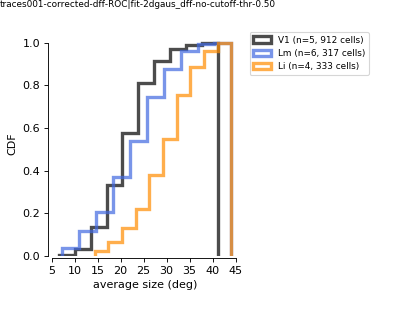

In [33]:
cdf = True
plot_type = 'cdf' if cdf else 'hist'

fig, ax = pl.subplots(figsize=(5,4))
fig.patch.set_alpha(1)
ax = compare_rf_size(rfdf, cdf=cdf, ax=ax, alpha=0.7)

pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfstatsdir, 'average-rf-size_no-repeats_%s.png' % plot_type))

In [200]:
reload(cc)

<module 'pipeline.python.retinotopy.convert_coords' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/convert_coords.py'>

# Compare cortical position vs. VF position

In [34]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = cc.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = cc.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [35]:
retinodir = os.path.join(rfdir, 'retinotopic-organization')
if not os.path.exists(retinodir):
    os.makedirs(retinodir)
print("Saving retino comparisons to: %s" % retinodir)

Saving retino comparisons to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/retinotopic-organization


In [36]:
rfdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff'

In [57]:
curr_outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/retinotopic-organization/sessions'

In [91]:
posdf[ (posdf['animalid']==animalid) & (posdf['session']==session) ]


index animalid            fov   session visual_area    xpos_fov  \
0       5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973   
1       7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644   
2      24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370   
3      25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740   
4      26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904   
5      32.0    JC076  FOV1_zoom2p0x  20190420          V1   99.201753   
6      42.0    JC076  FOV1_zoom2p0x  20190420          V1  223.203945   
7      48.0    JC076  FOV1_zoom2p0x  20190420          V1  349.113863   
8      49.0    JC076  FOV1_zoom2p0x  20190420          V1  373.914301   
9      52.0    JC076  FOV1_zoom2p0x  20190420          V1  469.300603   
10     60.0    JC076  FOV1_zoom2p0x  20190420          V1  579.948712   
11     67.0    JC076  FOV1_zoom2p0x  20190420          V1  370.098849   
12     89.0    JC076  FOV1_zoom2p0x  20190420          V1  663.888658   
13     92.0    JC076  FOV1_zoom2p0x  20190420          V1  736.382247   
14    106.0    JC076  FOV1_zoom2p0x  20190420          V1  541.794192   
15    107.0    JC076  FOV1_zoom2p0x  20190420          V1  534.163288   
16    108.0    JC076  FOV1_zoom2p0x  20190420          V1  545.609644   
17    114.0    JC076  FOV1_zoom2p0x  20190420          V1  656.257753   
18    115.0    JC076  FOV1_zoom2p0x  20190420          V1  644.811397   
19    117.0    JC076  FOV1_zoom2p0x  20190420          V1  640.995945   
20    119.0    JC076  FOV1_zoom2p0x  20190420          V1  673.427288   
21    122.0    JC076  FOV1_zoom2p0x  20190420          V1  656.257753   
22    137.0    JC076  FOV1_zoom2p0x  20190420          V1  784.075397   
23    138.0    JC076  FOV1_zoom2p0x  20190420          V1  818.414466   
24    142.0    JC076  FOV1_zoom2p0x  20190420          V1  858.476712   
25    169.0    JC076  FOV1_zoom2p0x  20190420          V1  829.860822   
26    175.0    JC076  FOV1_zoom2p0x  20190420          V1  745.920877   
27    198.0    JC076  FOV1_zoom2p0x  20190420          V1  490.285589   
28    209.0    JC076  FOV1_zoom2p0x  20190420          V1  461.669699   
29    210.0    JC076  FOV1_zoom2p0x  20190420          V1  471.208329   
...     ...      ...            ...       ...         ...         ...   
1532  202.0    JC099  FOV1_zoom2p0x  20190612          Li  785.983123   
1533  204.0    JC099  FOV1_zoom2p0x  20190612          Li  808.875836   
1534  208.0    JC099  FOV1_zoom2p0x  20190612          Li  915.708493   
1535  212.0    JC099  FOV1_zoom2p0x  20190612          Li  839.399452   
1536  217.0    JC099  FOV1_zoom2p0x  20190612          Li  877.553973   
1537  218.0    JC099  FOV1_zoom2p0x  20190612          Li  869.923068   
1538  219.0    JC099  FOV1_zoom2p0x  20190612          Li  875.646247   
1539  222.0    JC099  FOV1_zoom2p0x  20190612          Li  887.092603   
1540  223.0    JC099  FOV1_zoom2p0x  20190612          Li  911.893041   
1541  225.0    JC099  FOV1_zoom2p0x  20190612          Li  881.369425   
1542  232.0    JC099  FOV1_zoom2p0x  20190612          Li  923.339397   
1543  243.0    JC099  FOV1_zoom2p0x  20190612          Li  854.661260   
1544  247.0    JC099  FOV1_zoom2p0x  20190612          Li  816.506740   
1545    7.0    JC099  FOV1_zoom2p0x  20190617          Li  255.635288   
1546    9.0    JC099  FOV1_zoom2p0x  20190617          Li  314.774795   
1547   12.0    JC099  FOV1_zoom2p0x  20190617          Li  310.959342   
1548   17.0    JC099  FOV1_zoom2p0x  20190617          Li  362.467945   
1549   22.0    JC099  FOV1_zoom2p0x  20190617          Li  522.716932   
1550   30.0    JC099  FOV1_zoom2p0x  20190617          Li  381.545205   
1551   33.0    JC099  FOV1_zoom2p0x  20190617          Li  705.858630   
1552   34.0    JC099  FOV1_zoom2p0x  20190617          Li  726.843616   
1553   39.0    JC099  FOV1_zoom2p0x  20190617          Li  623.826411   
1554   43.0    JC099  FOV1_zoom2p0x  20190617          Li  600.9

#### Load converted RF positions

In [38]:
get_positions = False
pos_fpath = os.path.join(rfdir, 'rf_positions_no-repeats.pkl')

if os.path.exists(pos_fpath):
    print("Loading existing RF coord conversions...")
    try:
        with open(pos_fpath, 'rb') as f:
            aggr = pkl.load(f)
            posdf = aggr['posdf']
    except Exception as e:
        get_positions = True
else:
    get_positions = True
    
if get_positions:
    print("Calculating RF coord conversions...")
    pos_list = []
    for visual_area in visual_areas:
        d = rfdf[rfdf['visual_area']==visual_area]
        for (animalid, session, fov), g in d.groupby(['animalid', 'session', 'fov']):
            rffits = g.copy()
            rffits.index = g.index
            posdf = get_fov_coordinates(animalid, session, fov, rffits)
            pos_list.append(posdf)

    posdf = pd.concat(pos_list, axis=0).reset_index()
    with open(pos_fpath, 'wb') as f:
        aggr = {'posdf': posdf}
        pkl.dump(aggr, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e280bf_traces001_113086_traces001_caa531_traces001_d04d75_traces001_5735eb/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC083] 20190507 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190507 | FOV1_zoom2p0x)
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC083|201905

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -65.2537931034
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -273.06771264
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -247.986454133
STIM TYPE: gratings
**** File 7 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -77.663022508
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -69.4955423477
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -462.765859492
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -398.302083333
STIM TYPE: gratings
**** File 17 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -110.729083665
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -73.713140037
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -352.107373734
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -386.091308594
STIM TYPE: gratings
**** File 27 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -90.1321381142
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -123.296247531
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -369.625850111
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -419.91302426
STIM TYPE: gratings
**** File 37 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.1738712776
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -106.241196013
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -264.091546299
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -327.171203613
STIM TYPE: gratings
**** File 47 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 2 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -91.4344205413
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -87.3739358219
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -341.37678317
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -335.141071429
STIM TYPE: gratings
**** File 57 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 1 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -110.855741489
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -93.839309429
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -486.794040636
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -504.499773849
STIM TYPE: gratings
Nframes on: [22]
stim_durs (sec): [0.5]
XDATA concatenated: (246708, 226)
('*** LABELS:', (246708, 8))
STIM TYPE: gratings
[0.0, -30.0, 35.0, 5.0, -25.0, 40.0, 10.0, -20.0, 45.0, -50.0, 15.0, -15.0, 50.0, -45.0, 20.0, -10.0, -40.0, 25.0, -5.0, -35.0, 30.0]
[0.0, 5.0, -25.0, 10.0, -20.0, 15.0, -15.0, 20.0, -10.0, 25.0, -5.0]
Saving labels data... /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_4a4f2e_traces001_6cbcba_traces001_9ba767_traces001_6125f2_traces001_cd643e_traces001_f8b7f2/data_arrays/labels.npz
neuropil
Saving labels data... /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_4a4f2e_traces001_6cbcba_traces001_9ba767_traces001

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1001, in load
    dset = np.load(soma_fpath)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 370, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_1008f2_traces001_b46b24/data_arrays/np_subtracted.npz'


Created 225 contours for rois.
[JC097] 20190615 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190615|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC097/20190615/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_529f7e_traces001_2505d6_traces001_9e94c3/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190615 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 314 contours for rois.
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190615|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/combined_rfs10_static/traces/traces001_82391c_traces001_5005be_traces001_b13324/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190615 | FOV2_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 338 contours for rois.
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_30490f_traces001_8ad808/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190616 | FOV1_zoom2p0x | rfs | traces001
Found 63 raw file arrays.
**** File 1 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 0 (has 2911 frames)
... asking for 11 extra

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -109.960568843
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1165.73572981
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1164.86980146
STIM TYPE: gratings
**** File 11 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 10 (has 2911 frames)
... asking for 12 extra frames...
... L

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 0 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -103.371338084
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -683.755403352
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -689.465372415
STIM TYPE: gratings
**** File 21 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
...

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -376.403105945
STIM TYPE: gratings
**** File 30 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -115.769959405
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -967.085508471
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1007.28958382
STIM TYPE: gratings
**** File 31 of 63 *****
*** Excluding: []
/n/coxf

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -95.6127659574
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1086.38043258
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1121.78216782
STIM TYPE: gratings
**** File 40 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -105.769975787
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.6690419636
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -663.306350067
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -678.781007695
STIM TYPE: gratings
**** File 50 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 8 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -128.442429022
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -111.037873754
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -576.659216171
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -603.718133224
STIM TYPE: gratings
**** File 60 of 63 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 7 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -125.23297491
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1001, in load
    dset = np.load(soma_fpath)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 370, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_30490f_traces001_8ad808/data_arrays/np_subtracted.npz'


Created 432 contours for rois.
[JC097] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC097|20190617|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_f924db_traces001_85f376_traces001_db2b5e_traces001_acfba1_traces001_c58358_traces001_205616/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190617 | FOV1_zoom2p0x | rfs | traces001
Found 62 raw file arrays.
**** File 1 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 28

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 9 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -132.003561254
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -300.463684677
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -292.216349974
STIM TYPE: gratings
**** File 11 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 10 (has 29

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currdf['ix'] = [total_ix for _ in range(currdf.shape[0])]
/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currf0['ix'] = [total_ix for _ in range(currdf.shape[0])]


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -370.280549857
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.418346774
STIM TYPE: gratings
**** File 19 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 0 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -124.026909091
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -589.985548853
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -118.543071161
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -337.154537443
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -340.978219697
STIM TYPE: gratings
**** File 29 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -142.023255814
Showing initial drift correction (quantile: 0.10)
Min value for all RO

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -95.915693904
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -355.924314773
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -321.126805161
STIM TYPE: gratings
**** File 39 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -110.921708185
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -160.581908832
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -312.155451785
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -332.682783019
STIM TYPE: gratings
**** File 49 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -99.5266903915
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -132.117847411
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -335.635198937
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -343.629180908
STIM TYPE: gratings
**** File 59 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 7 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -121.25
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -503

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -95.3081123245
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -587.966061573
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -606.573032924
STIM TYPE: gratings
**** File 5 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run2
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -83.9316823228
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -283.256101413
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -257.595977783
STI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -417.782287598
STIM TYPE: gratings
**** File 16 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run2
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.5922521339
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -218.076481211
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -225.654388428
STIM TYPE: gratings
**** File 17 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run2
N tsecs: 2902
There are 462 total trials across all .t

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -84.1567967699
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -267.560783094
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -292.32010438
STIM TYPE: gratings
**** File 28 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run3
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.6181462141
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -253.912951968
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -262.091619318
STIM TYPE: gratings
**** File 39 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run3
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -82.2486231314
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -258.410830245
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -245.766276042
ST

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -314.740625
STIM TYPE: gratings
**** File 50 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run4
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -99.3484848485
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -514.083383289
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -537.452524038
STIM TYPE: gratings
**** File 51 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run4
N tsecs: 2902
There are 462 total trials across all .tif 

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.0812854442
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -390.505984303
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -425.517272949
STIM TYPE: gratings
**** File 62 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run4
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in bloc

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -80.0582655827
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -359.291232106
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -372.3640625
STIM TYPE: gratings
**** File 73 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run5
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2890 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -105.351028534
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -360.802354229
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -360.8203125
STIM T

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -723.826086957
STIM TYPE: gratings
**** File 84 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run5
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2890 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -93.9940594059
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -962.248206427
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -858.194886364
STIM TYPE: gratings
**** File 85 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run5
N tsecs: 2902
There are 462 total trials across all .t

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -73.4339393939
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -526.952512881
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -505.796512727
STIM TYPE: gratings
**** File 96 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run6
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2891 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in bloc

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -96.025198939
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -432.038191418
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -446.358901978
STIM TYPE: gratings
**** File 107 of 110 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/gratings_run6
N tsecs: 2902
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2352
... N unique frames: 2352
... Last frame to align: 2890 (N frames total, 2902)
... N tstamps: 2902
N frames per trial: 112
N tstamps: 2352
N trials in block: 21
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -103.432341001
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1143.85389798
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1140.52653503
ST

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -91.8419897586
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -367.36848173
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -403.241068026
STIM TYPE: gratings
**** File 5 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run1
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3834
... File: 4 (has 3850 frames)
... asking for 10 extra frames...
... Last frame to align: 3860 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.9909706546
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -93.2155517439
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -394.146494375
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -453.841003418
STIM TYPE: gratings
**** File 15 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run2
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3834
... File: 3 (has 3850 frames)
... asking for 10 extra frames...
... Last frame to align: 3860 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -104.791281374
Showing initial drift correction (quantile: 0.10)
Min value for a

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -117.798165138
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -349.477758624
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -423.526834239
STIM TYPE: gratings
**** File 25 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run3
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3834
... File: 2 (has 3850 frames)
... asking for 10 extra frames...
... Last frame to align: 3860 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -126.517628205
Showing initial drift correction (quantile: 0.10)
Min value for a

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -120.423160173
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -483.169832876
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -497.110286458
STIM TYPE: gratings
**** File 35 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run4
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3834
... File: 1 (has 3850 frames)
... asking for 10 extra frames...
... Last frame to align: 3860 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -100.028627196
Showing initial drift correction (quantile: 0.10)
Min value for a

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -104.10980663
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -846.370867863
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -794.284759964
STIM TYPE: gratings
**** File 45 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run5
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3833
... File: 0 (has 3850 frames)
... asking for 9 extra frames...
... Last frame to align: 3859 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -117.398328691
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -109.811594203
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -428.60752986
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -433.211475317
STIM TYPE: gratings
**** File 55 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/gratings_run5
N tsecs: 3850
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4704
... N unique frames: 3834
... File: 10 (has 3850 frames)
... asking for 10 extra frames...
... Last frame to align: 3860 (N frames total, 3850)
... N tstamps: 3850
... padding trial tstamps array... (should be 4704)
N frames per trial: 112
N tstamps: 4704
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -130.566980449
Showing initial drift correction (quantile: 0.10)
Min value for a

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -273.056995739
STIM TYPE: gratings
**** File 7 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -82.2892112421
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -422.119768166
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -351.481969572
STIM TYPE: gratings
**** File 8 of 61 *****
*** Excluding: []
/n/co

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -46.6573584906
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -220.013669099
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -207.534786184
STIM TYPE: gratings
**** File 17 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -59.786630655
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -94.0530434783
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -383.694486927
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -394.116344572
STIM TYPE: gratings
**** File 27 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -98.3904347826
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.9722425128
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -240.264721002
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -275.977393617
STIM TYPE: gratings
**** File 37 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -64.826880935
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.8084815321
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -272.22300104
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -280.673768939
STIM TYPE: gratings
**** File 47 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 252 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 2 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -76.1722574796
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -68.7513661202
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -281.804925406
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -289.708318537
STIM TYPE: gratings
**** File 57 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.7973052138
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -326.948667869
STIM TYPE: gratings
**** File 3 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run1
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 2 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -71.6270959088
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -277.521842882
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -274.477539062
STIM TYPE: gratings
**** File 4 of 66 *****
*** Excluding: []
/n/coxfs01

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -85.6501322751
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -334.357407985
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -349.076708984
STIM TYPE: gratings
**** File 13 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run2
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 1 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -90.2257653061
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -82.3237657865
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -490.428555052
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -394.439428711
STIM TYPE: gratings
**** File 23 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run3
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 0 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -76.4400760938
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -73.1602787456
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -322.99327434
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -324.515625
STIM TYPE: gratings
**** File 33 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run3
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 10 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -87.5534465534
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.5979020979
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -404.861405245
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -394.901071259
STIM TYPE: gratings
**** File 43 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run4
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 9 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -62.5364635365
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.525128866
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -215.314538344
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -220.506775532
STIM TYPE: gratings
**** File 53 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 8 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -63.0853080569
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.4680696662
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -247.552831937
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -261.138257576
STIM TYPE: gratings
**** File 63 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/rfs_run6
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 7 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -57.2244186047
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 183 contours for rois.
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_48087b_traces001_eb1ab1_traces001_34291b_traces001_83220d_traces001_15ae76_traces001_b0ea86/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC080 | 20190603 | FOV1_zoom2p0x | rfs | traces001
Found 66 raw file arrays.
**** File 1 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 28

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.4657727594
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -251.634085344
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -236.015838623
STIM TYPE: gratings
**** File 11 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 29

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -93.4121383204
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -339.239550781
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -326.260253906
STIM TYPE: gratings
**** File 21 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -132.410838059
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -279.073753077
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -301.513867187
STIM TYPE: gratings
**** File 31 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.5797101449
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -366.692631745
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -370.299272017
STIM TYPE: gratings
**** File 41 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -117.254216115
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -360.637065591
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -367.524147727
STIM TYPE: gratings
**** File 51 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -151.979625102
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -309.078258061
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -315.502148437
STIM TYPE: gratings
**** File 61 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 291

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.8039344262
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -268.764577118
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -282.408262311
STIM TYPE: gratings
**** File 2 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run1
N tsecs: 2920
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 1 (has 2920 frames)
... asking for 2 extra frames...
... Last frame to align: 2922 (N frames total, 2920)
... N tstamps: 2920
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -53.4314754098
Showing initial drift correction (quantile: 0.10)
Min value for all 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.7247706422
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -299.701615665
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -297.76875
STIM TYPE: gratings
**** File 12 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run2
N tsecs: 2920
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 0 (has 2920 frames)
... asking for 2 extra frames...
... Last frame to align: 2922 (N frames total, 2920)
... N tstamps: 2920
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -57.0343855693
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -70.8705137227
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -298.311622026
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -297.775916466
STIM TYPE: gratings
**** File 22 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run2
N tsecs: 2920
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2920 frames)
... asking for 2 extra frames...
... Last frame to align: 2922 (N frames total, 2920)
... N tstamps: 2920
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -95.3924205379
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -67.9222570533
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -202.087062906
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -222.802852746
STIM TYPE: gratings
**** File 32 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -80.3742534837
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -113.497478992
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -307.405357944
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -331.561149691
STIM TYPE: gratings
**** File 42 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -96.2773770492
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.9914224446
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -241.442740104
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -244.349007989
STIM TYPE: gratings
**** File 52 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -118.160404624
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -102.32852459
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -223.245389545
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -259.515779194
STIM TYPE: gratings
**** File 62 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -90.4941176471
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -84.128440367
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -253.672383991
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -260.878621419
STIM TYPE: gratings
**** File 72 of 77 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/gratings_run7
N tsecs: 2911
There are 301 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -76.0978043912
Showing initial drift correction (quantile: 0.10)
Min value for all

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 367, in aggregate_experiment_runs
    frame_shift = 0 if 'block_frame_offset' not in mwinfo[trials_in_block[0]].keys() else mwinfo[trials_in_block[0]]['block_frame_offset']
IndexError: list index out of range
Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 367, in aggregate_experiment_runs
    frame_shift = 0 if 'block_frame_offset' not in mwinfo[trials_in_block[0]].keys() else mwinfo[trials_in_block[0]]['block_frame_offset']
IndexError: list index out of range
Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 367, in aggregate_experiment_runs
    frame_shift = 0 if 'block_frame_offset' not in mwinfo[trials_in_block[0]].keys() else mwinfo[trials_in_block[0]]['block_frame_offset']
Inde

Nframes on: [22]
stim_durs (sec): [0.5]
XDATA concatenated: (273497, 257)
('*** LABELS:', (273497, 8))
STIM TYPE: gratings
[0.0, -30.0, 35.0, 5.0, -25.0, 40.0, 10.0, -20.0, 45.0, -50.0, 15.0, -15.0, 50.0, -45.0, 20.0, -10.0, -40.0, 25.0, -5.0, -35.0, 30.0]
[0.0, 5.0, -25.0, 10.0, -20.0, 15.0, -15.0, 20.0, -10.0, 25.0, -5.0]
Saving labels data... /n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_052a22_traces001_70273f_traces001_3a6035_traces001_d15b0d_traces001_7aee74_traces001_20da33_traces001_abde16/data_arrays/labels.npz
neuropil
Saving labels data... /n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_052a22_traces001_70273f_traces001_3a6035_traces001_d15b0d_traces001_7aee74_traces001_20da33_traces001_abde16/data_arrays/neuropil.npz
np_subtracted
Saving labels data... /n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_052a22_traces001_70273f_traces001_3a6035_traces00

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -51.0110981308
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -299.829358205
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -291.254882812
STIM TYPE: gratings
**** File 9 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Las

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -54.2172312224
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -411.753791256
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -433.977490234
STIM TYPE: gratings
**** File 19 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -76.4398364486
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -234.569205351
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -242.768344351
STIM TYPE: gratings
**** File 29 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 291

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -67.9309462916
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -286.920746813
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -311.276306152
STIM TYPE: gratings
**** File 39 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 252 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 5 (has 2911 frames)
... asking for 12 extra frames...
... La

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.9439793947
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -244.123264897
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -276.421634615
STIM TYPE: gratings
**** File 49 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.3608316566
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -477.402053376
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -495.596166992
STIM TYPE: gratings
**** File 59 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 291

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -60.0396716826
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -257.695613669
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -283.795572917
STIM TYPE: gratings
**** File 5 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 4 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.1605415861
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.2118421053
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -334.078419059
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -323.555871212
STIM TYPE: gratings
**** File 15 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 3 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -71.3400321543
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -69.7073333333
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -323.061222909
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -335.040527344
STIM TYPE: gratings
**** File 25 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 2 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -94.0719008264
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -104.763760049
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -505.717204057
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -487.308959961
STIM TYPE: gratings
**** File 35 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 1 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -62.5648854962
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -67.5475430759
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -287.897627758
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -296.121189024
STIM TYPE: gratings
**** File 45 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 0 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -83.9335180055
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -108.489827856
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -782.1597377
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -729.550882975
STIM TYPE: gratings
**** File 55 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 10 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -67.3625096824
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -94.4507042254
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -367.219757108
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -404.802258614
STIM TYPE: gratings
**** File 65 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 9 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.3344947735
Showing initial drift correction (quantile: 0.10)
Min value for all ROI

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -836.098668195
STIM TYPE: gratings
**** File 6 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -83.6
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -245.461903584
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -247.21447577
STIM TYPE: gratings
**** File 7 of 55 *****
*** Excluding: []
/n/coxfs01/2p-d

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -91.4452319588
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -489.152291004
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -572.119650136
STIM TYPE: gratings
**** File 16 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -85.6707768187
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -98.4200589971
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -390.546419315
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -441.703662817
STIM TYPE: gratings
**** File 26 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -100.0
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.3920581655
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -550.70133106
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -539.497209821
STIM TYPE: gratings
**** File 36 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 2 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -99.4962610469
Showing initial drift correction (quantile: 0.10)
Min value for all

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -115.004283966
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -343.748224935
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -389.627839543
STIM TYPE: gratings
**** File 46 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 1 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -105.545103093
Showing initial drift correction (quantile: 0.10)
Min value for al

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -115.344916345
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -325.998001039
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -359.648879523
STIM TYPE: gratings
Nframes on: [22]
stim_durs (sec): [0.5]
XDATA concatenated: (205590, 227)
('*** LABELS:', (205590, 8))
STIM TYPE: gratings
[0.0, -30.0, 35.0, 5.0, -25.0, 40.0, 10.0, -20.0, 45.0, -50.0, 15.0, -15.0, 50.0, -45.0, 20.0, -10.0, -40.0, 25.0, -5.0, -35.0, 30.0]
[0.0, 5.0, -25.0, 10.0, -20.0, 15.0, -15.0, 20.0, -10.0, 25.0, -5.0]
Saving labels data... /n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_7569de_traces001_48c1d7_traces001_46c882_traces001_676ef4_traces001_c8a2e7/data_arrays/labels.npz
neuropil
Saving labels data... /n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_7569de_traces001_48c1d7_traces001_46c882_traces001_676ef

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 271 contours for rois.
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190602 | FOV1_zoom2p0x | rfs | traces001
Found 68 raw file arrays.
**** File 1 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 9 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -73.3606557377
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -481.65361897
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -493.798236269
STIM TYPE: gratings
**** File 11 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 10 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 2 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.8222621185
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -323.025843647
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -320.148903918
STIM TYPE: gratings
**** File 21 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 291

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 1 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.7794729542
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -402.959062896
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -451.493533973
STIM TYPE: gratings
**** File 31 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 270 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 2 (has 2911 frames)
... asking for 10 extra frames...
... La

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -63.3253731343
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -311.858177117
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -314.102040816
STIM TYPE: gratings
**** File 41 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 5 (has 291

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -88.3310679612
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -259.713591229
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -272.05311334
STIM TYPE: gratings
**** File 51 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 2 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.552184466
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -250.271605935
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -269.128669508
STIM TYPE: gratings
**** File 61 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 3 (has 2911

np_subtracted
Saving labels data... /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_0b8258_traces001_1cd00d_traces001_d63263_traces001_1aa474_traces001_92356a_traces001_21f6e1_traces001_54d307/data_arrays/np_subtracted.npz
raw
Saving labels data... /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_0b8258_traces001_1cd00d_traces001_d63263_traces001_1aa474_traces001_92356a_traces001_21f6e1_traces001_54d307/data_arrays/raw.npz
*****corrected offsets!*****
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1001, in load
    dset = np.load(soma_fpath)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 370, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz'


Created 356 contours for rois.
[JC091] 20190614 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190614 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 533 contours for rois.
[JC099] 20190609 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190609|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_f96aeb_traces001_e2d7ba_traces001_6e3eae_traces001_5d2fdc/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190609 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 311 contours for rois.
[JC099] 20190612 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_c582b7_traces001_d52cff_traces001_50de2d_traces001_1a8b92/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190612 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 269 contours for rois.
[JC099] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190617 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 102 contours for rois.


In [39]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0    5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1    7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2   24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3   25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4   26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

In [71]:
posdf.groupby(['visual_area'])['index'].count()

visual_area
Li    333
Lm    317
V1    912
Name: index, dtype: int64

##  Linear regression

In [40]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

In [41]:
def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)

#### Cortical position vs. VF position by DATASET

In [42]:
# Create output subdir for visual area plots
curr_outdir = os.path.join(retinodir, 'sessions')
if not os.path.exists(curr_outdir):
    os.makedirs(curr_outdir)
print("Saving session plots to: %s" % curr_outdir)

Saving session plots to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/retinotopic-organization/sessions


In [43]:
# Set fit and plot params
el_color = 'blue'
az_color = 'red'
indep_var = 'fov'
dep_var = 'fov' if indep_var=='rf' else 'rf'

In [82]:
plot_azimuth = True

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


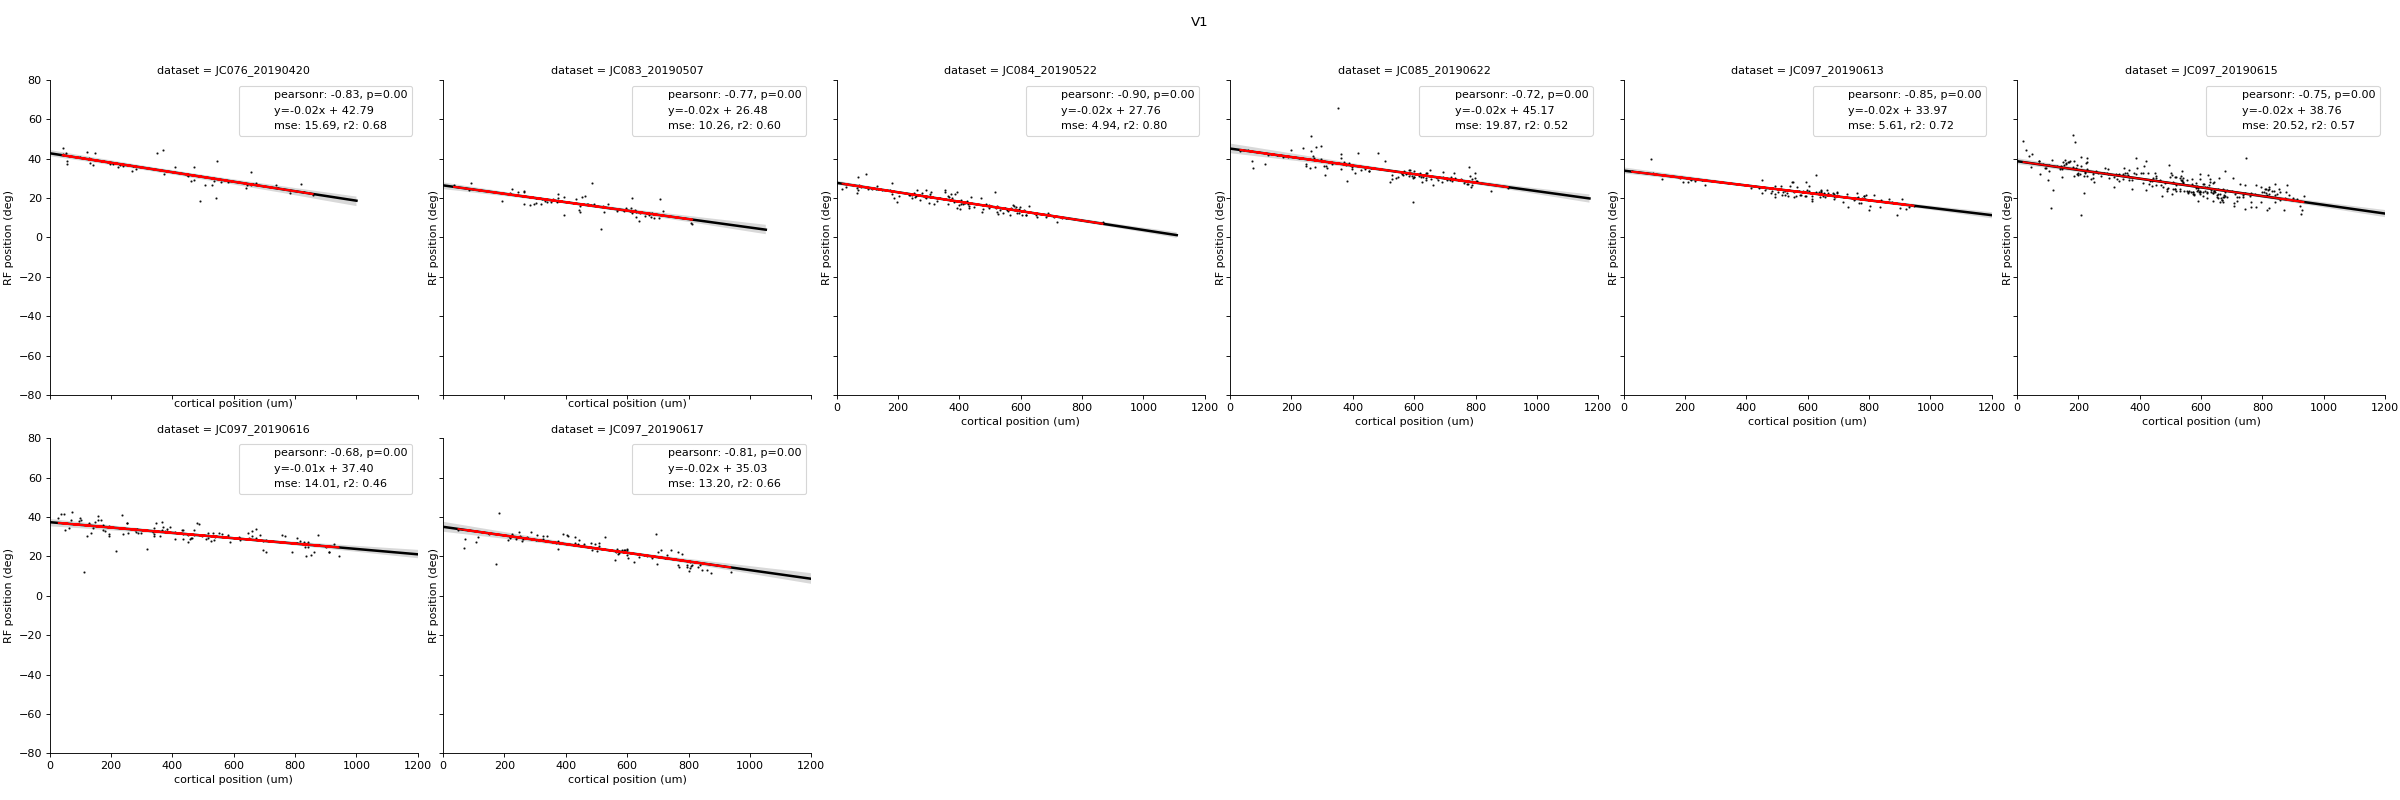

<IPython.core.display.Javascript object>


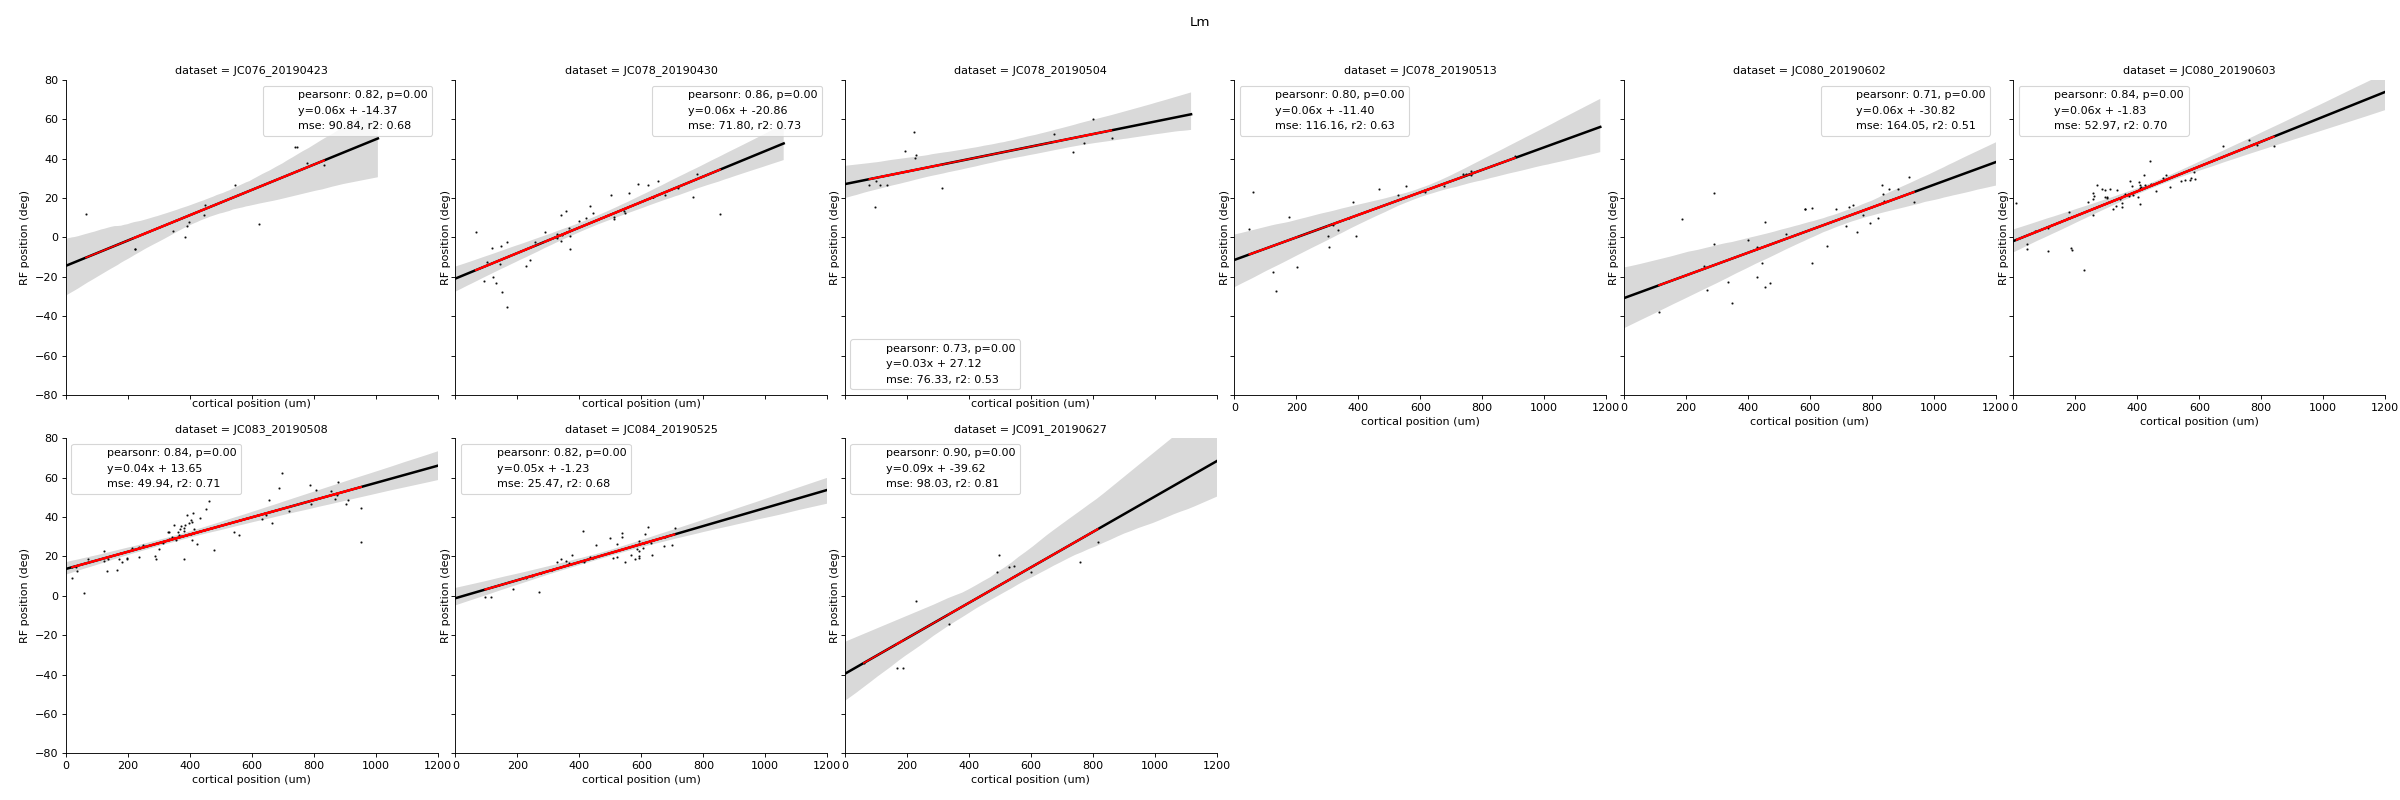

<IPython.core.display.Javascript object>


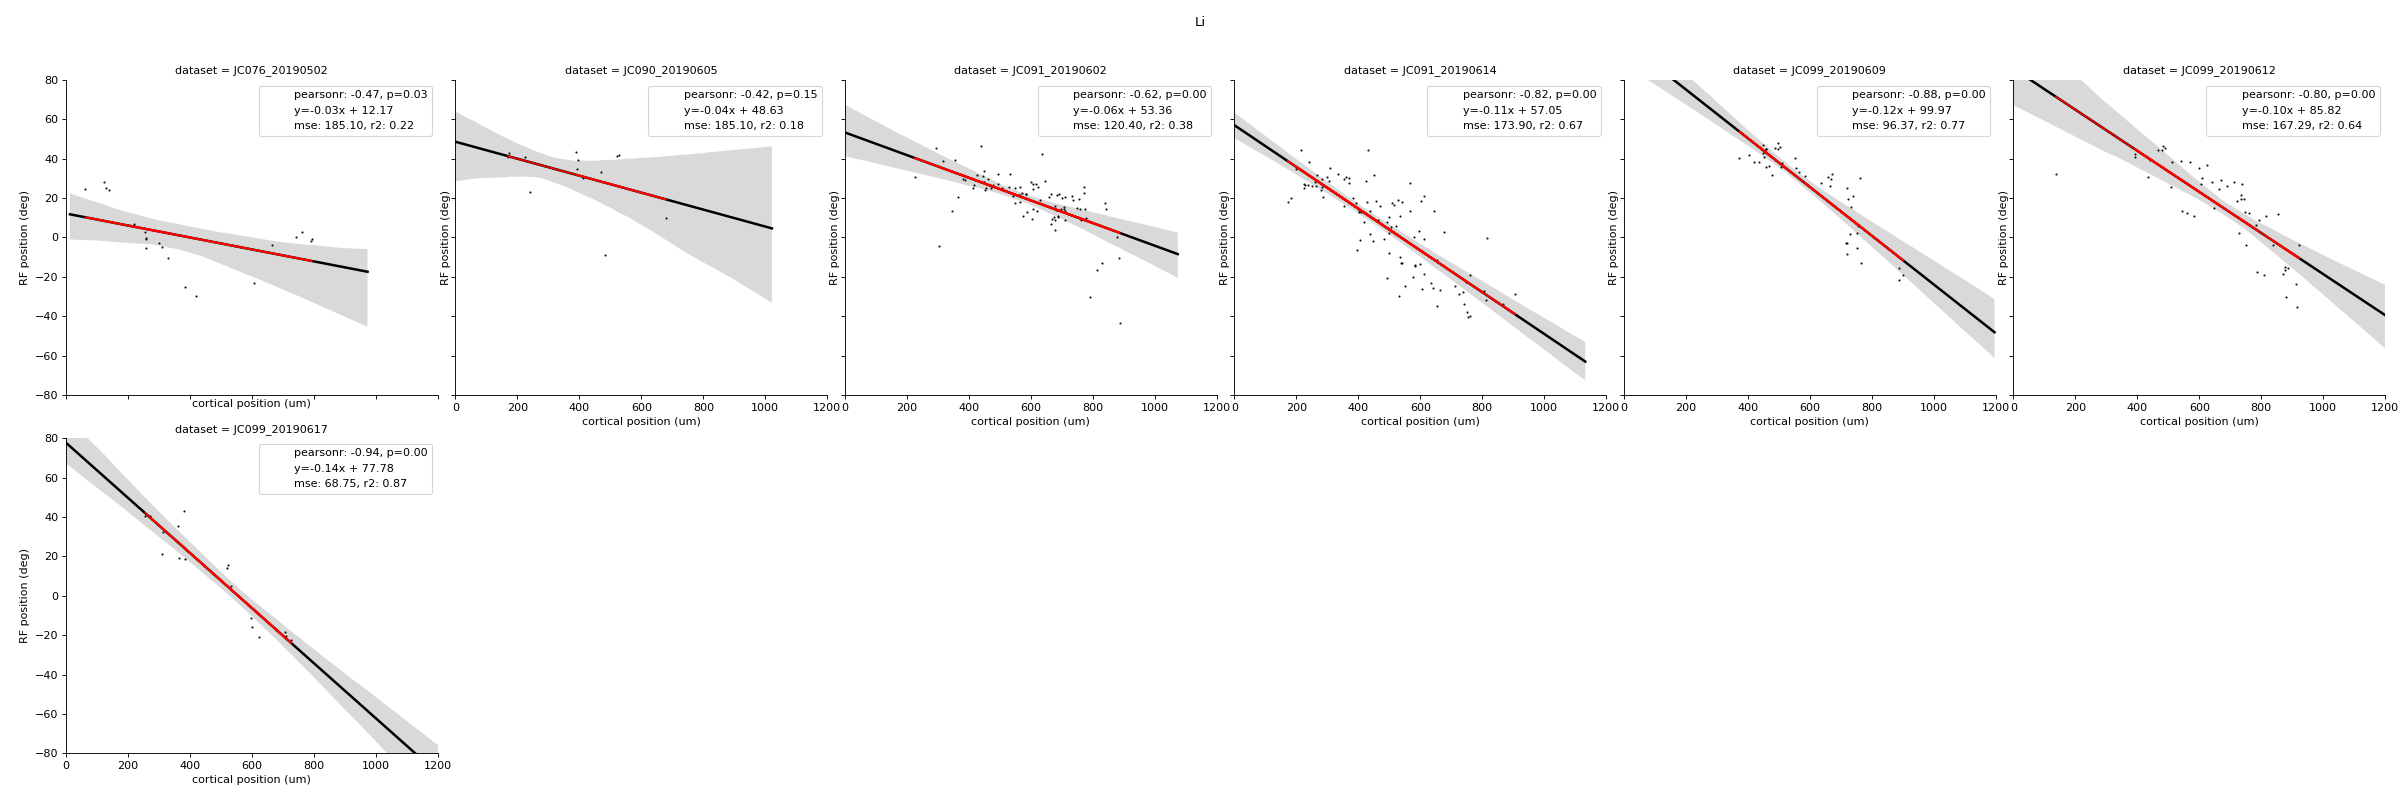

In [83]:

xlabel = 'cortical position (um)' if indep_var == 'fov' else 'RF position (deg)'
ylabel = 'RF position (deg)' if indep_var == 'fov' else 'cortical position (um)'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

axname = 'xpos' if plot_azimuth else 'ypos'

regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = posdf[posdf['visual_area']==visual_area]
    tmpd['dataset'] = ['%s_%s' % (a, s) for a, s, in zip(tmpd['animalid'], tmpd['session'])]

    # Plot regression w/ CI
    g = sns.lmplot('%s_%s' % (axname, indep_var), '%s_%s' % (axname, dep_var), data=tmpd, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)
    
    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, indep_var)]
        yv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, dep_var)]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Fit line
        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)
        
        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

        regr_stats.append(pd.Series({'dataset': curr_dset,
                                   'mse': mse,
                                   'slope': float(regr.coef_),
                                   'intercept': float(regr.intercept_),
                                   'r2': r2,
                                     'pearsonr': p,
                                    'visual_area': visual_area}))

    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    figname = '%s-regr-on-%s_%s' % ('azimuth' if plot_azimuth else 'elevation', indep_var, visual_area)
    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))


#### Calculate goodness of fit and aggregate by visual area

In [48]:
def get_regr_stats(xv, yv):
    fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
    mse = skmetrics.mean_squared_error(yv, fitv)
    r2 = skmetrics.r2_score(yv, fitv)
    residuals = yv - fitv
    evfit = pd.Series({#'residuals': yv-fitv,
                          'RMSE': np.sqrt(float(mse)),
                          'R2': float(r2),
                          'slope': float(regr.coef_),
                          'intercept': float(regr.intercept_),
                          'Exp-Var': float(skmetrics.explained_variance_score(yv, fitv)),
                          'MedAE': skmetrics.median_absolute_error(yv, fitv)})
    
    return evfit

In [49]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax


In [50]:

dflist = []
for (visual_area, animalid, session, fov), g in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    tmpevs = []
    xv_az = g['xpos_%s' % indep_var]
    yv_az = g['xpos_%s' % dep_var]

    evfit = get_regr_stats(xv_az, yv_az)
    for c in evfit.index.tolist():
        evfit['%s_az' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    xv_el = g['ypos_%s' % indep_var]
    yv_el = g['ypos_%s' % dep_var]
    evfit = get_regr_stats(xv_el, yv_el)
    for c in evfit.index.tolist():
        evfit['%s_el' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    evdf = pd.concat(tmpevs, axis=0)
    evdf['dataset'] = '_'.join([animalid, session])
    evdf['visual_area'] = visual_area

    dflist.append(evdf)

retinostats = pd.concat(dflist, axis=1).T

In [51]:
retinostats.head()

Exp-Var_az MedAE_az     R2_az  RMSE_az intercept_az   slope_az Exp-Var_el  \
0   0.216872  10.6906  0.216872   13.605      12.1651 -0.0303807   0.623921   
1   0.177438  7.86615  0.177438   13.605      48.6301 -0.0430867   0.154092   
2   0.380671  4.76435  0.380671  10.9725      53.3614 -0.0575448  0.0136189   
3   0.666371  9.39375  0.666371  13.1873      57.0454  -0.106058  0.0589466   
4   0.766051  7.82892  0.766051  9.81679       99.965  -0.123822   0.584473   

  MedAE_el      R2_el  RMSE_el intercept_el    slope_el         dataset  \
0  2.93271   0.623921  7.41112     -8.17065   0.0332828  JC076_20190502   
1  3.01214   0.154092  6.83784      0.57856  -0.0179948  JC090_20190605   
2  5.23106  0.0136189  7.88947      -7.8349  0.00338153  JC091_20190602   
3  6.26147  0.0589466   10.701     -6.91977  0.00819604  JC091_20190614   
4  2.95629   0.584473   4.9296      12.7476  -0.0309479  JC099_20190609   

  visual_area  
0          Li  
1          Li  
2          Li  
3          Li  
4          Li

In [52]:
retinostats['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

#### Plot regression stats by visual area

In [53]:
common_metrics = ['visual_area', 'dataset']
regr_metrics = np.unique([m.split('_')[0] for m in retinostats.columns.tolist() if m not in common_metrics])
print regr_metrics

['Exp-Var' 'MedAE' 'R2' 'RMSE' 'intercept' 'slope']


In [54]:
# Get average of axes
for metric in regr_metrics:
    retinostats[metric] = np.abs(retinostats[['%s_az' % metric, '%s_el' % metric]]).mean(axis=1)



In [55]:
# curr_metrics = regr_metrics.copy()
# curr_metrics = np.append(curr_metrics, common_fields)
# avgmetrics = retinostats[curr_metrics]

exclude=['intercept']
curr_metrics = [m for m in regr_metrics if m not in exclude]


<IPython.core.display.Javascript object>


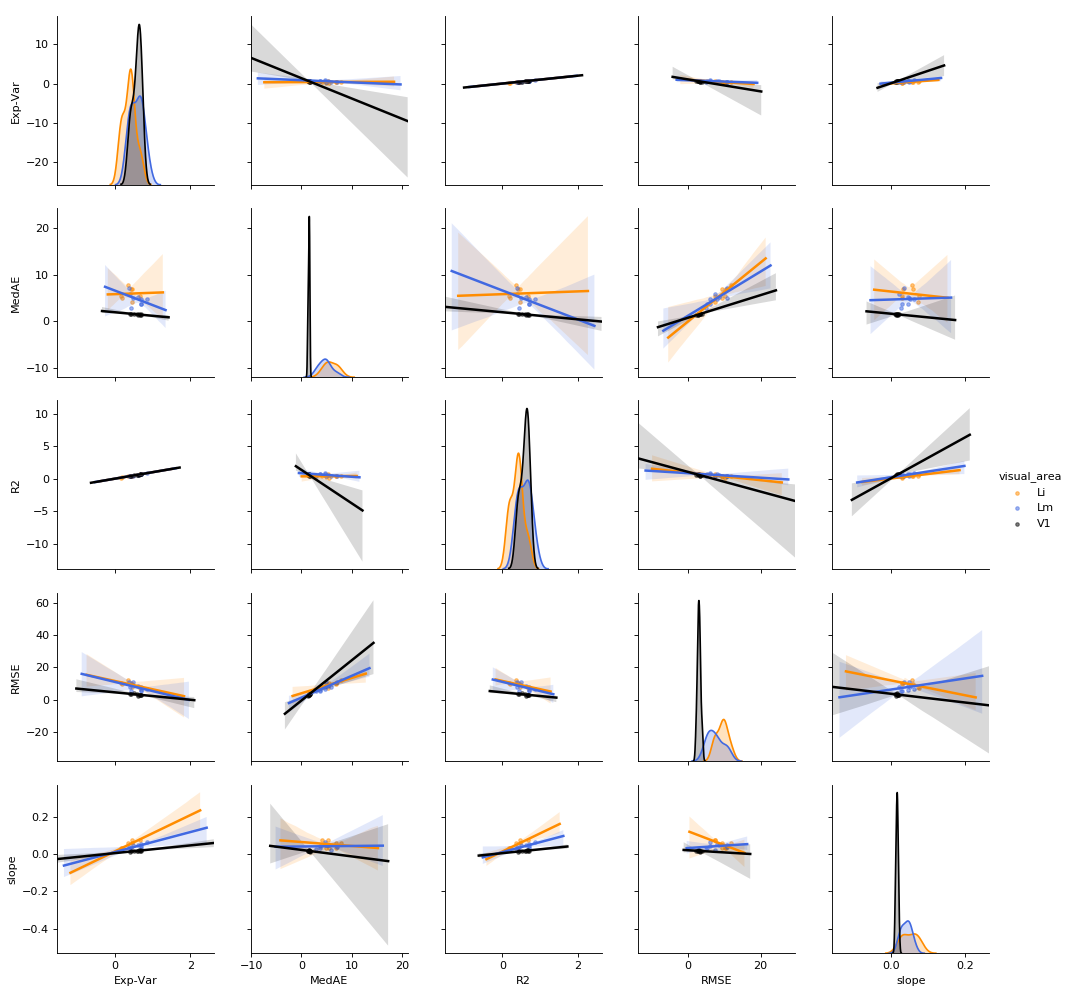

In [58]:
g= sns.pairplot(retinostats, vars=curr_metrics, hue='visual_area', palette=area_colors,
            kind='reg', plot_kws=dict(scatter_kws=dict(s=10, alpha=0.5, linewidth=1)),
            diag_kind='kde') #, diag_kws=dict(histtype='step', normed=False))
g.fig.patch.set_alpha(1)
pl.savefig(os.path.join(retinodir, 'regression-metrics_regr-on-%s.png' % indep_var))

#### Plot subset of summary stats

<IPython.core.display.Javascript object>


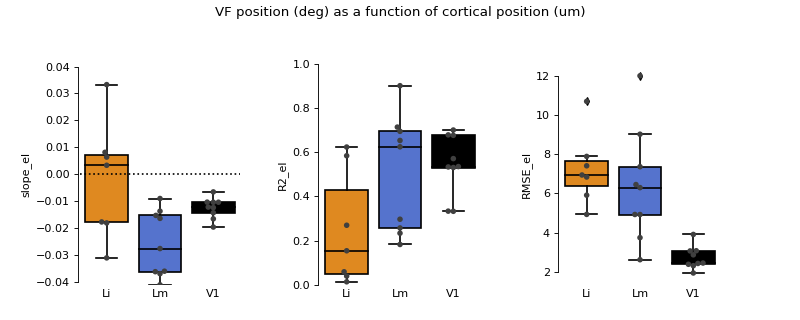

el_stats-regr-on-fov


In [61]:
plot_azimuth = False

if isinstance(plot_azimuth, bool):
    whichax = 'az' if plot_azimuth else 'el'
else:
    whichax=None

if indep_var == 'fov':
    figtitle = 'VF position (deg) as a function of cortical position (um)'
else:
    figtitle = 'cortical position (um) as a function of VF position (deg)'

fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(retinostats, metric='slope', whichax=whichax, ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(retinostats, metric='R2',  whichax=whichax, ax=axes[1], area_colors=area_colors)
ax3 = boxplot_visual_area(retinostats, metric='RMSE', whichax=whichax, ax=axes[2], area_colors=area_colors)
#ax4 = boxplot_visual_area(retinostats, metric='MedAE', whichax=whichax, ax=axes[3], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle(figtitle)

figname = '%s_stats-regr-on-%s' % ('bothaxes' if plot_azimuth is None else whichax, indep_var)
pl.savefig(os.path.join(retinodir, '%s.png' % figname))
print figname

#### Calculate residuals

In [67]:

def calculate_distance(df, indep_var='fov'):
    
    if indep_var=='fov':
        dep_var = 'rf'
    elif indep_var == 'rf':
        dep_var = 'fov'
    
    regr = LinearRegression()
    xv = np.array(df['xpos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['xpos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_az'] = yv - fitv

    mse_az = skmetrics.mean_squared_error(yv, fitv)
    r2_az = skmetrics.r2_score(yv, fitv)
    df['mse_az'] = [mse_az for _ in range(len(fitv))]
    df['r2_az'] = [r2_az for _ in range(len(fitv))]
    
    regr = LinearRegression()
    xv = np.array(df['ypos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['ypos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_el'] = yv - fitv
    
    mse_el = skmetrics.mean_squared_error(yv, fitv)
    r2_el = skmetrics.r2_score(yv, fitv) #, multioutput='variance_weighted')
    df['mse_el'] = [mse_el for _ in range(len(fitv))]
    df['r2_el'] = [r2_el for _ in range(len(fitv))]
    
    return df

#### Plot residuals by visual area

In [82]:
print indep_var

fov


In [231]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<IPython.core.display.Javascript object>


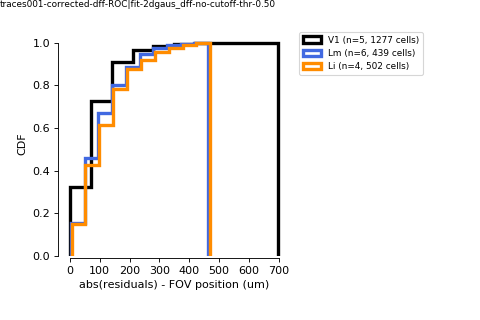

residuals_regr-on-rf_cdf


In [192]:

cdf = True

xlabel = 'abs(residuals) - RF positions (deg)' if indep_var=='fov' else 'abs(residuals) - FOV position (um)'
ylabel = 'CDF' if cdf else 'fraction'

fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['resid_el', 'resid_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
figname = 'residuals_regr-on-%s_%s' % (indep_var, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(retinodir, '%s.png' % figname))
print(figname)

#### Compare metrics (MSE v R2):

<IPython.core.display.Javascript object>


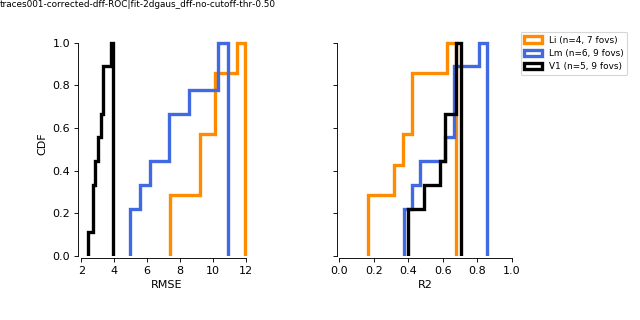

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
cdf = True
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in retinostats.groupby(['visual_area']):
    tmpd['animalid'] = [d.split('_')[0] for d in tmpd['dataset']]
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['dataset'].count()

    metric = 'RMSE'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel(metric)
    ax.set_ylabel('CDF' if cdf else 'fraction')
    
    metric = 'R2'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

sns.despine(ax=axes[0], trim=True, offset=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(retinodir, 'RMSE-R2_regr-on-%s_%s.png' % (indep_var, 'cdf' if cdf else 'hist')))

#### Compare Azimuth v Elevation fits by Visual area

In [73]:
retinostats.head()

Exp-Var_az MedAE_az     R2_az    RMSE_az intercept_az  slope_az Exp-Var_el  \
0   0.216872  10.6906  0.216872  13.605015      12.1651 -0.030381   0.623921   
1   0.177438  7.86615  0.177438  13.605014      48.6301 -0.043087   0.154092   
2   0.380671  4.76435  0.380671  10.972541      53.3614 -0.057545  0.0136189   
3   0.666371  9.39375  0.666371  13.187297      57.0454 -0.106058  0.0589466   
4   0.766051  7.82892  0.766051   9.816790       99.965 -0.123822   0.584473   

  MedAE_el     R2_el    RMSE_el intercept_el  slope_el         dataset  \
0  2.93271  0.623921   7.411116     -8.17065  0.033283  JC076_20190502   
1  3.01214  0.154092   6.837840      0.57856 -0.017995  JC090_20190605   
2  5.23106  0.013619   7.889466      -7.8349  0.003382  JC091_20190602   
3  6.26147  0.058947  10.700957     -6.91977  0.008196  JC091_20190614   
4  2.95629  0.584473   4.929601      12.7476 -0.030948  JC099_20190609   

  visual_area   Exp-Var     MedAE        R2       RMSE  intercept     slope  
0          Li  0.420397  6.811673  0.420397  10.508065  10.167870  0.031832  
1          Li  0.165765  5.439145  0.165765  10.221427  24.604325  0.030541  
2          Li  0.197145  4.997705  0.197145   9.431004  30.598171  0.030463  
3          Li  0.362659  7.827609  0.362659  11.944127  31.982605  0.057127  
4          Li  0.675262  5.392604  0.675262   7.373195  56.356309  0.077385

<IPython.core.display.Javascript object>


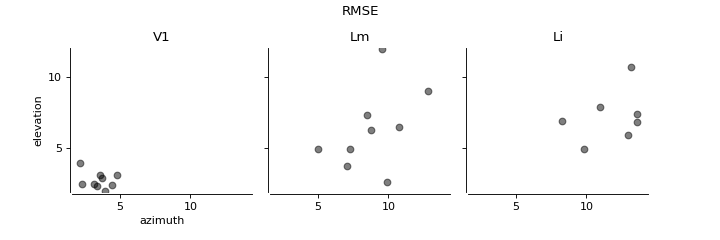

Text(0.5,0.98,u'RMSE')

In [74]:
metric = 'RMSE'
az_color = 'r'
el_color = 'b'

minv = min([0, tmpd['%s_az' % metric].min(), tmpd['%s_el' % metric].min()])
maxv = round(max([tmpd['%s_az' % metric].max(), tmpd['%s_el' % metric].max()]))

fig, axes = pl.subplots(1,3, figsize=(9,3), sharey=True, sharex=True) 
for ax, visual_area in zip(axes.flat, visual_areas):
    tmpd = retinostats[retinostats['visual_area']==visual_area]
    ax.scatter(np.array(tmpd['%s_az' % metric].values).astype(float), 
               np.array(tmpd['%s_el' % metric].values).astype(float), c='k', alpha=0.5)

    ax.set_title(visual_area)
    ax.axis('equal')
    #ax.set_aspect('equal') #, 'box')
    #ax.set(xlim=(minv, maxv), ylim=(minv, maxv))
    #sns.despine(ax=ax, trim=False, offset=2)
    #ticks = [round(i, 2) for i in np.linspace(minv, maxv, 4)]
    #ax.set_xticks(ticks)

ticks = ax.get_xticks() if ax.get_xticks()[-1] > ax.get_yticks()[-1] else ax.get_yticks()
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.axis('equal')
axes[0].set_xlabel('azimuth')
axes[0].set_ylabel('elevation')

sns.despine(trim=False, offset=2)
#axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(wspace=0.1, top=0.8, left=0.1, right=0.9, bottom=0.2)
fig.suptitle(metric)


# Pairwise distances

In [75]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')

#### Create output dir

In [76]:
pairwisedir = os.path.join(rfdir, 'pairwise-distances')
if not os.path.exists(pairwisedir):
    os.makedirs(pairwisedir)
print("Saving pairwise-distance analysis to: %s" % pairwisedir)

Saving pairwise-distance analysis to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/pairwise-distances


#### Look at PW distances of by dataset

In [77]:
# Create subdir
curr_sessiondir = os.path.join(pairwisedir, 'sessions')
if not os.path.exists(curr_sessiondir):
    os.makedirs(curr_sessiondir)

In [92]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0    5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1    7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2   24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3   25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4   26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

In [78]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# SPLIT pw-dists

# Split PW dist calculation by azimuth/elevation

In [113]:
import itertools

testdf = pd.DataFrame({0: np.linspace(0, 10, 10)})
                      
[i-v for (i, v) in itertools.product(testdf.values, testdf.values)]


[array([-1.11111111]),
 array([-2.22222222]),
 array([-3.33333333]),
 array([-4.44444444]),
 array([-5.55555556]),
 array([-6.66666667]),
 array([-7.77777778]),
 array([-8.88888889]),
 array([-10.]),
 array([ 1.11111111]),
 array([-1.11111111]),
 array([-2.22222222]),
 array([-3.33333333]),
 array([-4.44444444]),
 array([-5.55555556]),
 array([-6.66666667]),
 array([-7.77777778]),
 array([-8.88888889]),
 array([ 2.22222222]),
 array([ 1.11111111]),
 array([-1.11111111]),
 array([-2.22222222]),
 array([-3.33333333]),
 array([-4.44444444]),
 array([-5.55555556]),
 array([-6.66666667]),
 array([-7.77777778]),
 array([ 3.33333333]),
 array([ 2.22222222]),
 array([ 1.11111111]),
 array([-1.11111111]),
 array([-2.22222222]),
 array([-3.33333333]),
 array([-4.44444444]),
 array([-5.55555556]),
 array([-6.66666667]),
 array([ 4.44444444]),
 array([ 3.33333333]),
 array([ 2.22222222]),
 array([ 1.11111111]),
 array([-1.11111111]),
 array([-2.22222222]),
 array([-3.33333333]),
 array([-4.4444444

<IPython.core.display.Javascript object>


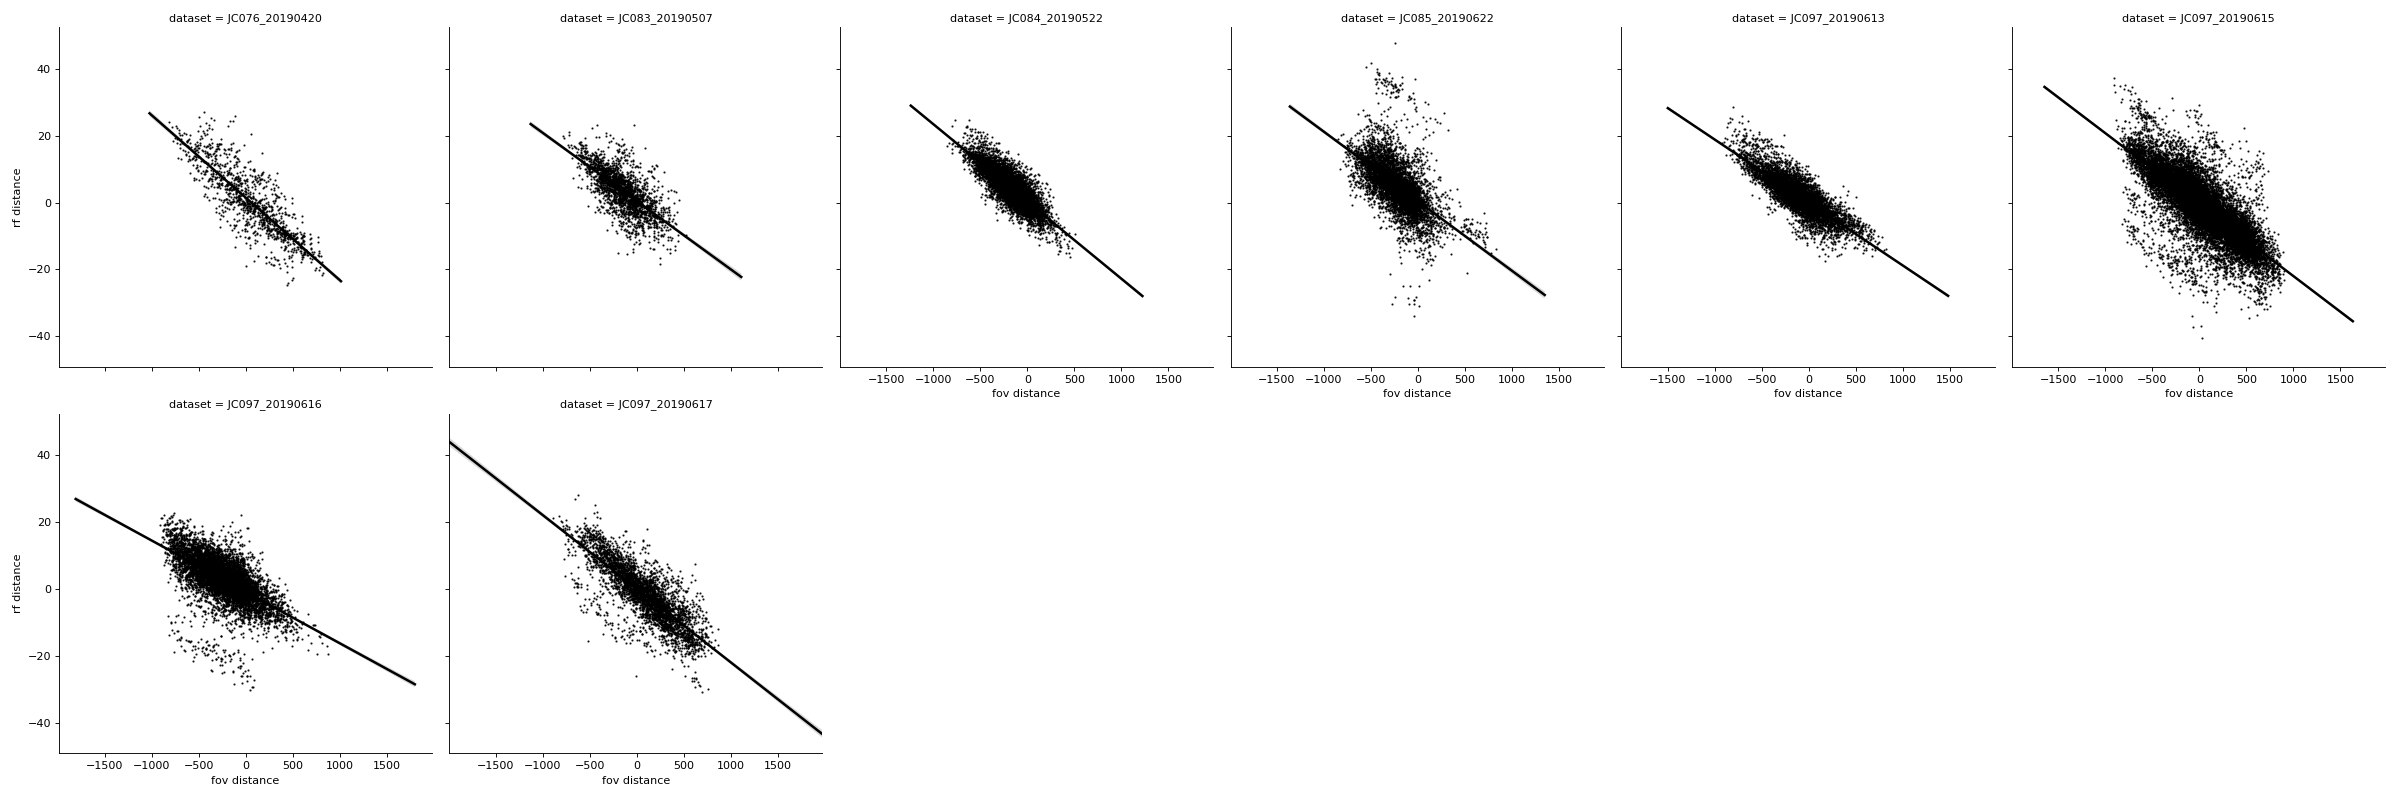

In [118]:
tmpd = pf[pf['visual_area']==visual_area]

# Get all pairwise distances for each fov:
tmpd_list = []
for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
    cdists = g['%s_%s' % (axname, indep_var)].values
    #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
    pwdiffs_ind = [t1-t2 for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]
    
    rdists = g['%s_%s' % (axname, dep_var)].values
    #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
    pwdiffs_dep = [t1-t2 for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]
    
    assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"
             
    tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                        '%s distance' % dep_var: pwdiffs_dep,
                        'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
    tmpd_list.append(tmpd)
pw = pd.concat(tmpd_list, axis=0)

# Plot regression w/ CI
g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)


In [129]:
plot_azimuth= True

<IPython.core.display.Javascript object>


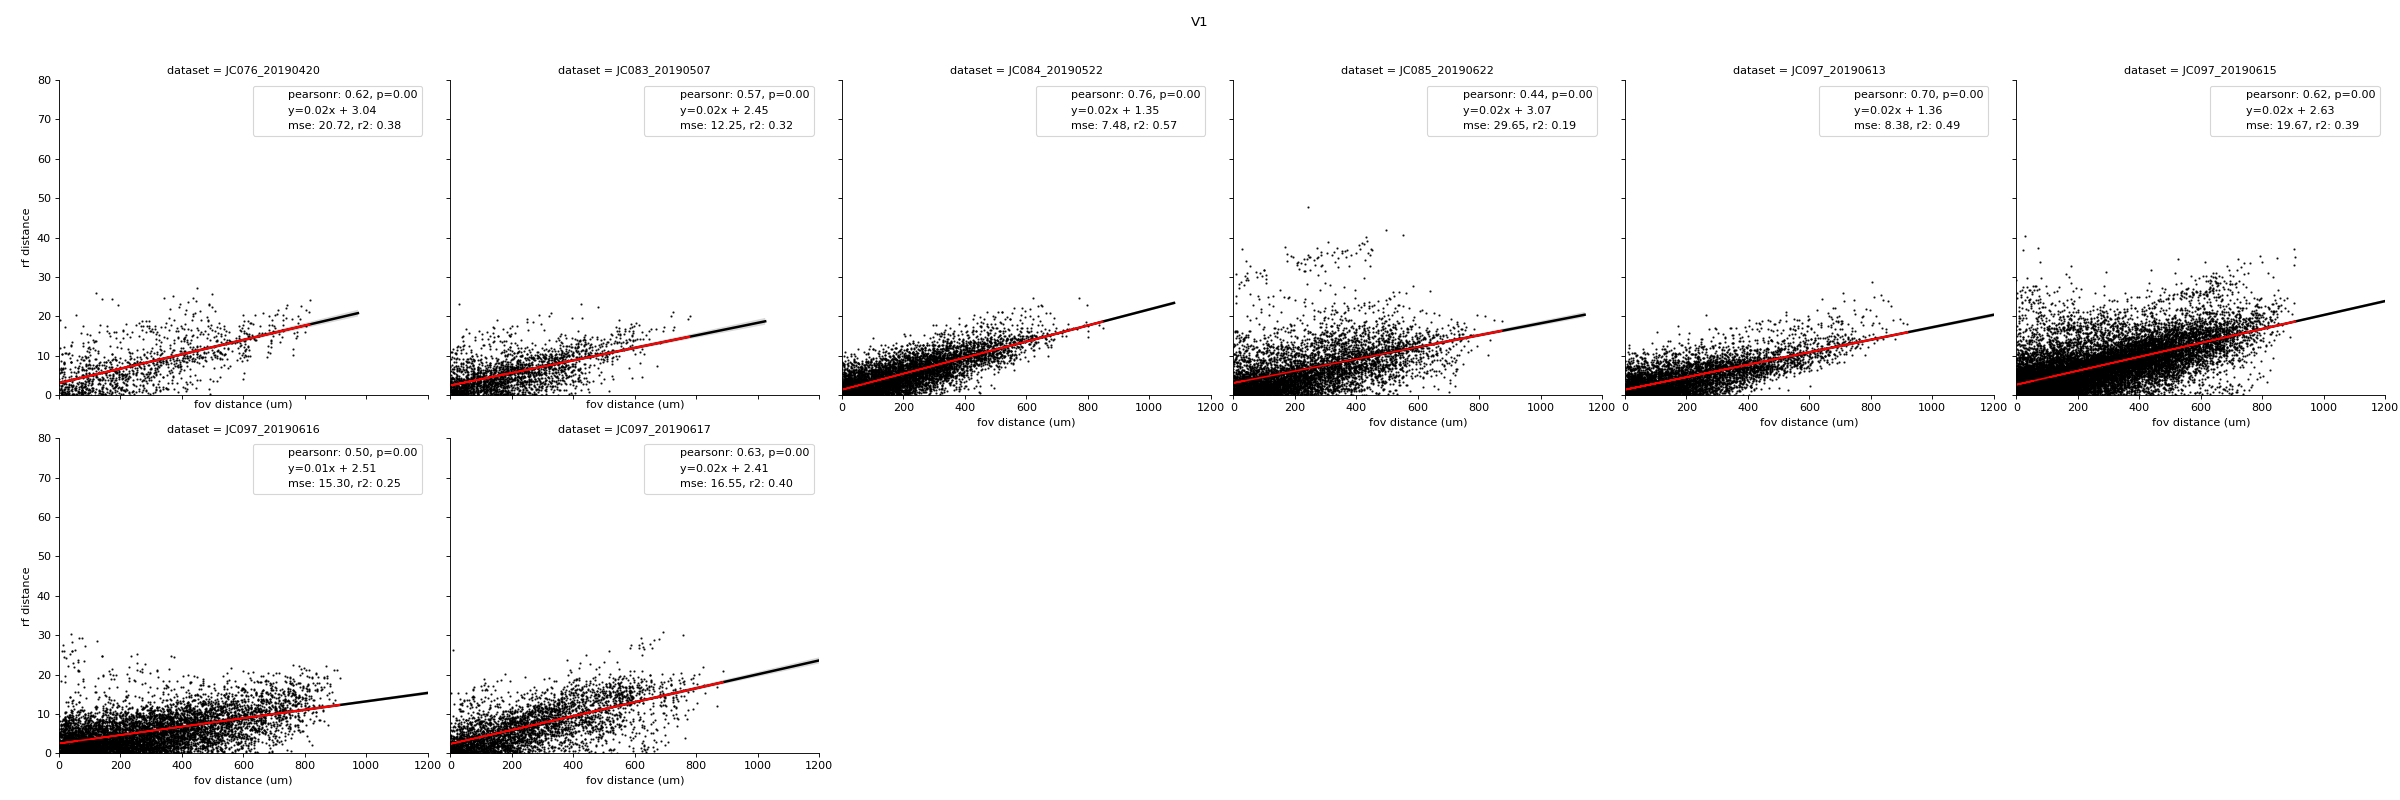

<IPython.core.display.Javascript object>


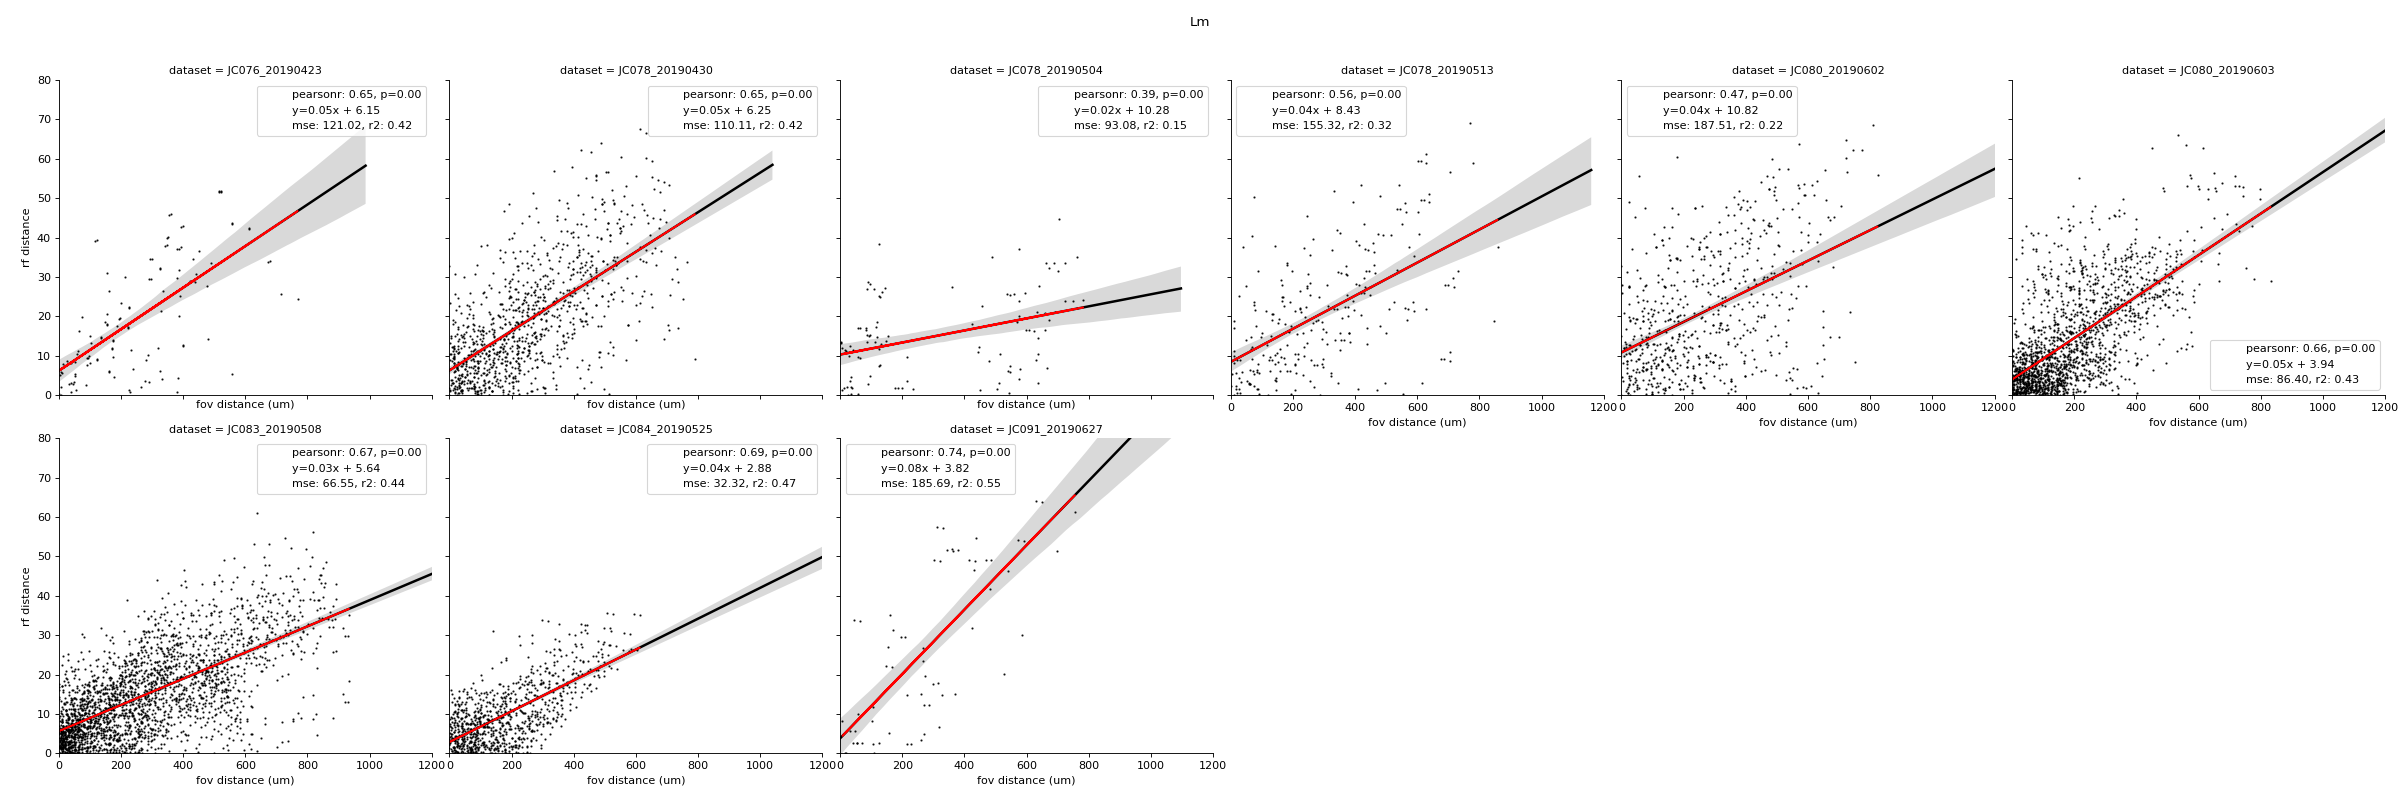

<IPython.core.display.Javascript object>


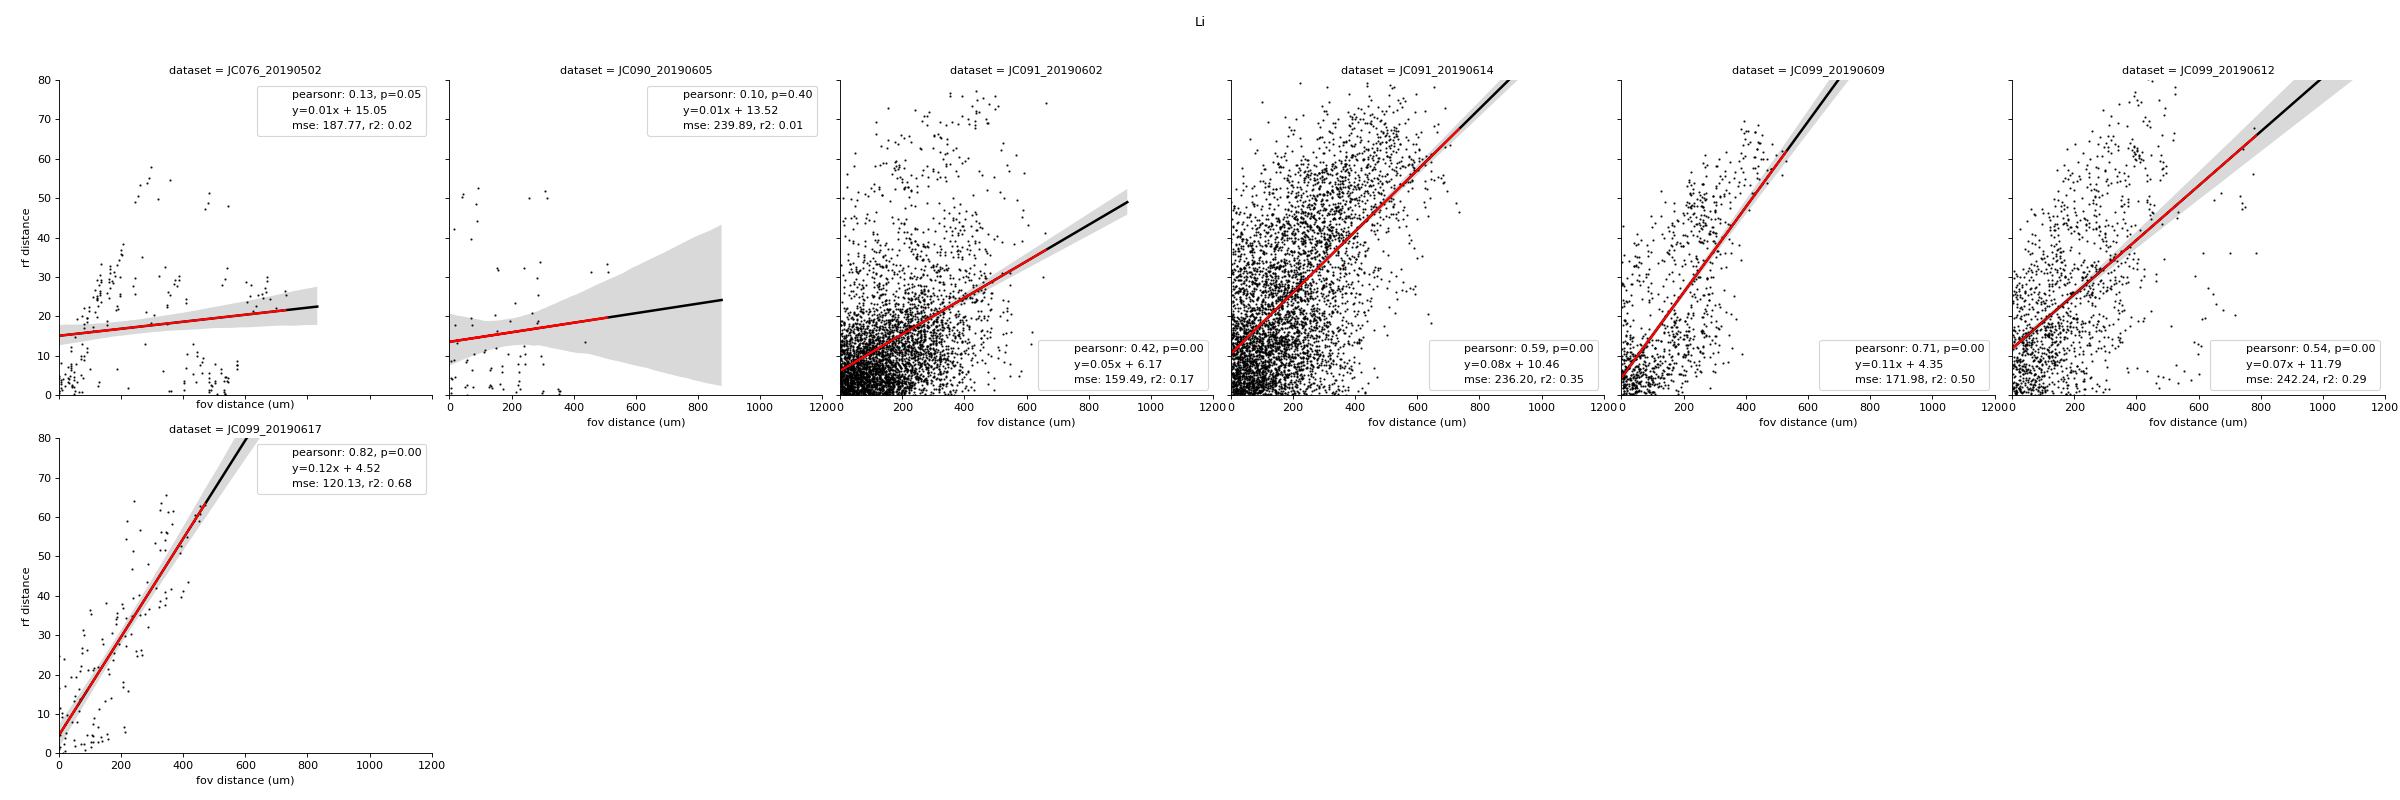

In [130]:
dep_var = 'rf' if indep_var=='fov' else 'fov'
axname = 'xpos' if plot_azimuth else 'ypos'

plot_str = 'azimuth' if plot_azimuth else 'elevation'
xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = g['%s_%s' % (axname, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = [ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]

        rdists = g['%s_%s' % (axname, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = [ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]

        assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"

        tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                            '%s distance' % dep_var: pwdiffs_dep,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)


    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([0, xmax])
        ax.set_ylim([0, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, '%s-only_regr-on-%s_%s.png' % (plot_str, visual_area, indep_var)))


In [122]:
curr_sessiondir

'/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/pairwise-distances/sessions'

### Get stats for PW dists split by el, az

In [132]:
pwdiffs_ind

[200.31123287671235,
 164.0644383561644,
 387.26838356164387,
 572.31780821917812,
 574.22553424657542,
 543.70191780821926,
 522.71693150684939,
 444.5001643835617,
 40.062246575342471,
 91.570849315068486,
 82.032219178082187,
 97.294027397260265,
 156.43353424657533,
 34.339068493150705,
 40.062246575342471,
 89.663123287671255,
 40.062246575342471,
 110.64810958904113,
 82.032219178082215,
 0.0,
 36.246794520547951,
 186.95715068493149,
 372.00657534246574,
 373.91430136986304,
 343.39068493150688,
 322.40569863013701,
 244.18893150684931,
 160.24898630136988,
 291.88208219178085,
 282.34345205479451,
 297.60526027397259,
 356.74476712328772,
 165.97216438356165,
 160.24898630136988,
 110.6481095890411,
 160.24898630136988,
 89.663123287671226,
 118.27901369863014,
 200.31123287671235,
 223.20394520547944,
 408.25336986301369,
 410.16109589041099,
 379.63747945205483,
 358.65249315068496,
 280.43572602739727,
 124.00219178082193,
 255.6352876712329,
 246.09665753424659,
 261.358465

In [134]:

pwstats_split = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    for axn in ['xpos', 'ypos']:

        # Get all pairwise distances for current fov:
        cdists = g['%s_%s' % (axn, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = np.array([ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]])

        rdists = g['%s_%s' % (axn, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = np.array([ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]])


        # Get linear fit:
        fitdist, regr = fit_linear_regr(pwdiffs_ind, pwdiffs_dep, return_regr=True)
        mse = skmetrics.mean_squared_error(pwdiffs_dep, fitdist)
        r2 = skmetrics.r2_score(pwdiffs_dep, fitdist)
        res = pd.Series({'visual_area': visual_area,
                             'animalid': animalid,
                             'session': session,
                             'fov': fov,
                             'RMSE': np.sqrt(mse),
                             'R2': r2,
                             'slope': float(regr.coef_),
                             'intercept': float(regr.intercept_),
                             'axis': axn,
                             'dataset': '_'.join([animalid, session, fov])})
        pwstats_split.append(res)

pwstats_split = pd.concat(pwstats_split, axis=1).T

In [135]:
pwstats_split.

R2     RMSE animalid  axis                       dataset  \
0     0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1      0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3   0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4       0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   
5     0.0960888  6.65553    JC091  ypos  JC091_20190602_FOV1_zoom2p0x   
6      0.351522  15.3687    JC091  xpos  JC091_20190614_FOV1_zoom2p0x   
7     0.0112163  9.19012    JC091  ypos  JC091_20190614_FOV1_zoom2p0x   
8       0.49955   13.114    JC099  xpos  JC099_20190609_FOV1_zoom2p0x   
9      0.323039  5.31777    JC099  ypos  JC099_20190609_FOV1_zoom2p0x   
10     0.287199  15.5639    JC099  xpos  JC099_20190612_FOV1_zoom2p0x   
11       0.1383  5.44076    JC099  ypos  JC099_20190612_FOV1_zoom2p0x   
12     0.679327  10.9604    JC099  xpos  JC099_20190617_FOV1_zoom2p0x   
13   0.00482567  5.82389    JC099  ypos  JC099_20190617_FOV1_zoom2p0x   
14      0.42496   11.001    JC076  xpos  JC076_20190423_FOV1_zoom2p0x   
15     0.241486  11.0925    JC076  ypos  JC076_20190423_FOV1_zoom2p0x   
16     0.423184  10.4935    JC078  xpos  JC078_20190430_FOV1_zoom2p0x   
17      0.39685  8.49739    JC078  ypos  JC078_20190430_FOV1_zoom2p0x   
18     0.150751  9.64803    JC078  xpos  JC078_20190504_FOV1_zoom2p0x   
19    0.0164859  5.85896    JC078  ypos  JC078_20190504_FOV1_zoom2p0x   
20     0.315239  12.4626    JC078  xpos  JC078_20190513_FOV1_zoom2p0x   
21      0.32029  7.72405    JC078  ypos  JC078_20190513_FOV1_zoom2p0x   
22     0.216695  13.6936    JC080  xpos  JC080_20190602_FOV2_zoom2p0x   
23    0.0125971  9.61073    JC080  ypos  JC080_20190602_FOV2_zoom2p0x   
24      0.43416  9.29506    JC080  xpos  JC080_20190603_FOV1_zoom2p0x   
25     0.431625   5.9198    JC080  ypos  JC080_20190603_FOV1_zoom2p0x   
26     0.443367  8.15776    JC083  xpos  JC083_20190508_FOV1_zoom2p0x   
27     0.388379  4.36827    JC083  ypos  JC083_20190508_FOV1_zoom2p0x   
28     0.471738  5.68544    JC084  xpos  JC084_20190525_FOV1_zoom2p0x   
29     0.286761  4.11877    JC084  ypos  JC084_20190525_FOV1_zoom2p0x   
30     0.553624  13.6268    JC091  xpos  JC091_20190627_FOV1_zoom2p0x   
31     0.725605  3.61182    JC091  ypos  JC091_20190627_FOV1_zoom2p0x   
32     0.382244  4.55231    JC076  xpos  JC076_20190420_FOV1_zoom2p0x   
33        0.369  2.33265    JC076  ypos  JC076_20190420_FOV1_zoom2p0x   
34      0.31967  3.50049    JC083  xpos  JC083_20190507_FOV1_zoom2p0x   
35     0.360049  2.98218    JC083  ypos  JC083_20190507_FOV1_zoom2p0x   
36     0.573864   2.7349    JC084  xpos  JC084_20190522_FOV1_zoom2p0x   
37     0.262586  4.99888    JC084  ypos  JC084_20190522_FOV1_zoom2p0x   
38     0.194563  5.44496    JC085  xpos  JC085_20190622_FOV1_zoom2p0x   
39       0.1167  2.44978    JC085  ypos  JC085_20190622_FOV1_zoom2p0x   
40     0.490521  2.89537    JC097  xpos  JC097_20190613_FOV1_zoom2p0x   
41     0.278751  2.59788    JC097  ypos  JC097_20190613_FOV1_zoom2p0x   
42     0.503683  3.89318    JC097  xpos  JC097_20190615_FOV1_zoom2p0x   
43     0.441118  2.76399    JC097  ypos  JC097_20190615_FOV1_zoom2p0x   
44     0.271608  4.95946    JC097  xpos  JC097_20190615_FOV2_zoom2p0x   
45     0.298287  3.62507    JC097  ypos  JC097_20190615_FOV2_zoom2p0x   
46     0.246991  3.91112    JC097  xpos  JC097_20190616_FOV1_zoom2p0x   
47     0.155874  3.15333    JC097  ypos  JC097_20190616_FOV1_zoom2p0x   
48     0.401128  4.06798    JC097  xpos  JC097_20190617_FOV1_zoom2p0x   
49      0.26715  3.50805    JC097  ypos  JC097_20190617_FOV1_zoom2p0x   

              fov intercept   session        slope visual_area  
0   FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1   FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2   FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3   FOV1_zoom2p0x   7.84417  

#### Plot PW stts for SPLITs

<IPython.core.display.Javascript object>


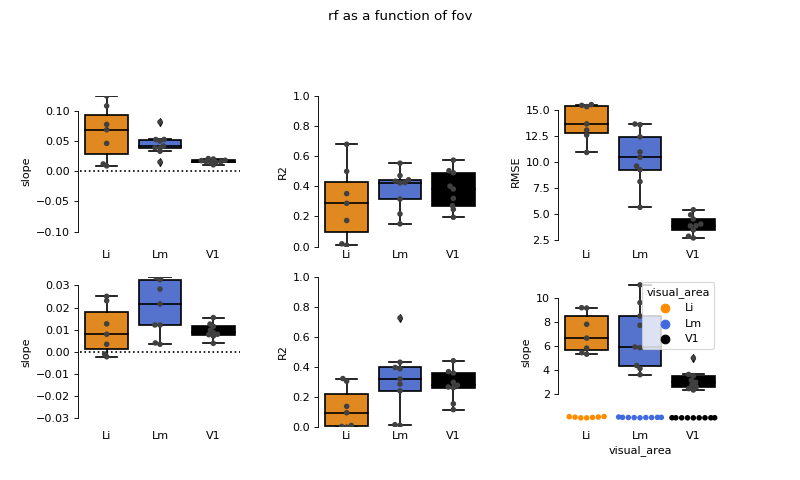

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
fig, axes = pl.subplots(2, 3, figsize=(10,6))
fig.patch.set_alpha(1)

for ai, axn in enumerate(['xpos', 'ypos']):
    curr_pwstats = pwstats_split.groupby(['axis']).get_group(axn)

    ax1 = boxplot_visual_area(curr_pwstats, metric='slope', ax=axes[ai, 0], area_colors=area_colors)

    ax2 = boxplot_visual_area(curr_pwstats, metric='R2', ax=axes[ai, 1], area_colors=area_colors)

    ax3 = boxplot_visual_area(curr_pwstats, metric='RMSE', ax=axes[ai, 2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'split-axes_stats-regr-on-%s.png' % indep_var))

In [ ]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax



#### PW dists, split:  Plot slope for Az and El on same 

In [157]:
axdf.groupby(['visual_area'])['slope'].apply(np.mean)

visual_area
Li    0.063929
Lm    0.045119
V1    0.016610
Name: slope, dtype: float64

<IPython.core.display.Javascript object>


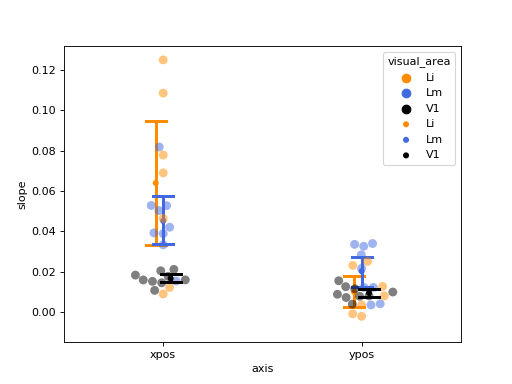

In [211]:
fig, ax = pl.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([0, 0],[0, 0], marker='s')
b = ax.scatter([0, 0],[0, 0], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="axis", y="slope", hue="visual_area",data=pwstats_split, 
                   palette=area_colors,size=8,ax=ax, dodge=False, alpha=0.5,facecolor='none')
N_hues = len(pd.unique(pwstats_split.visual_area))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
#update legend
ax.legend(c[-3:],pd.unique(pwstats_split.visual_area))


mvs = pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)

sns.pointplot(x='axis', y='slope', hue='visual_area', data=pwstats_split, ci=95, capsize=0.1,
             palette=area_colors, dodge=True, apha=0.7, markers='.', join=False)


In [185]:
pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)


axis  visual_area
xpos  Li             0.063929
      Lm             0.045119
      V1             0.016610
ypos  Li             0.009870
      Lm             0.020191
      V1             0.009434
Name: slope, dtype: float64

In [238]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

<IPython.core.display.Javascript object>


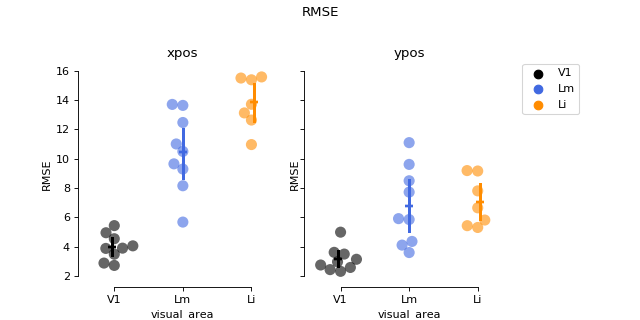

In [240]:

metric = 'RMSE'
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

for ax, axn in zip(axes.flat, ['xpos', 'ypos']):
    axdf = pwstats_split[pwstats_split['axis']==axn]
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

       # ax.plot(ai, mval, color=area_colors[visual_area], marker='_', markersize=30)
        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axn)
    if axn == 'xpos':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8)
fig.suptitle(metric)

pl.savefig(os.path.join(pairwisedir, '%s_pw-dists_ax-v-el.png' % metric))


In [141]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

# Combine axes: PW distance regression for each dataset for each visual area

In [79]:
indep_var

'fov'

<IPython.core.display.Javascript object>


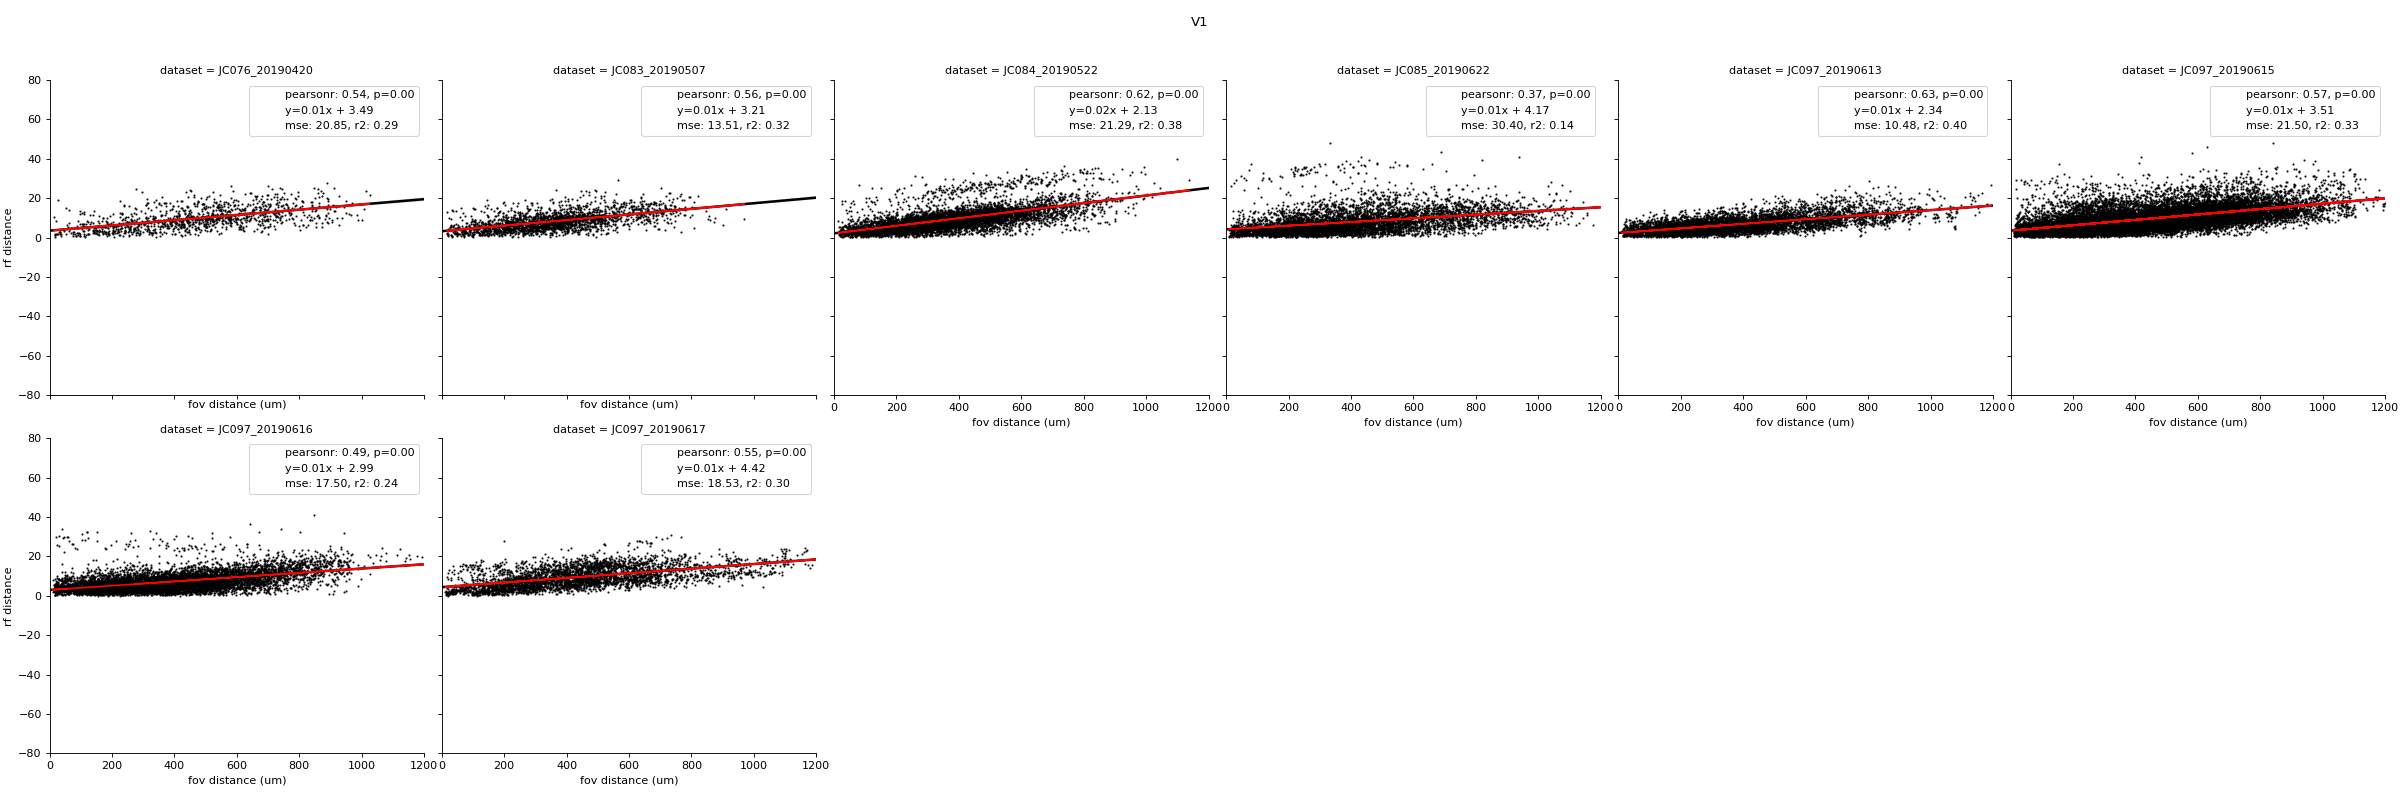

<IPython.core.display.Javascript object>


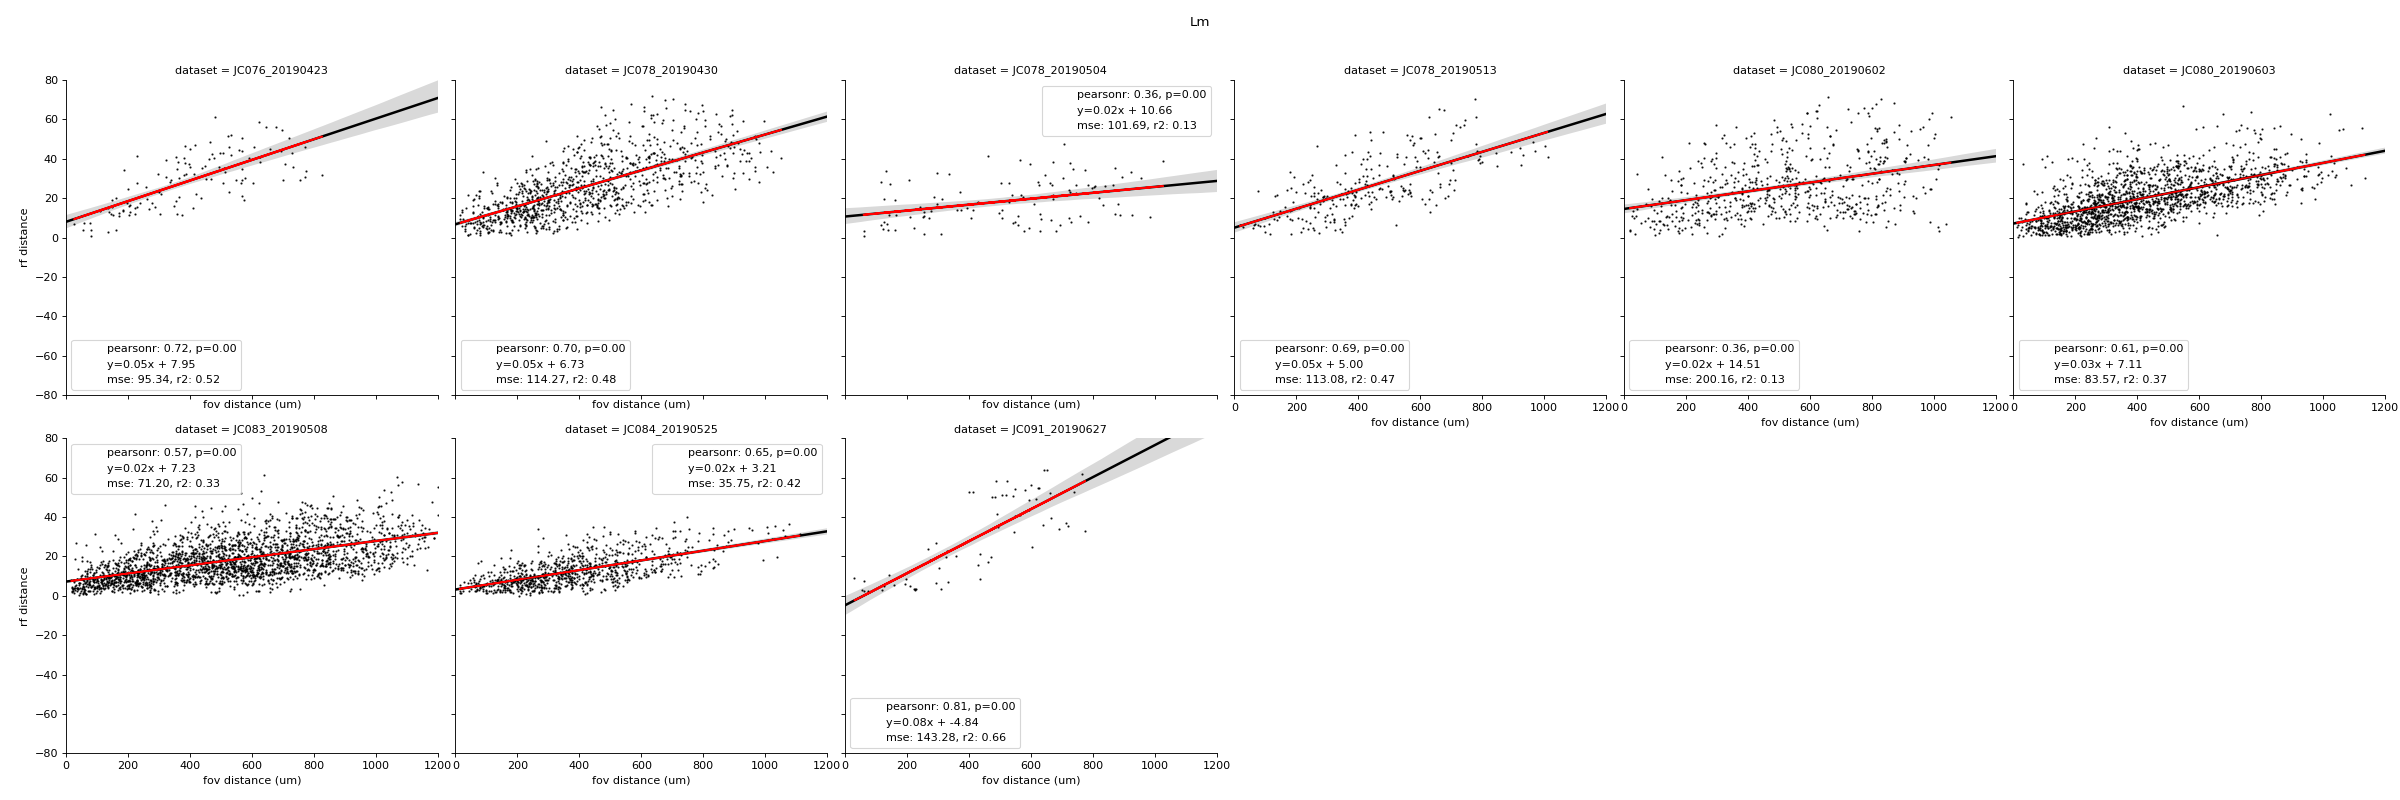

<IPython.core.display.Javascript object>


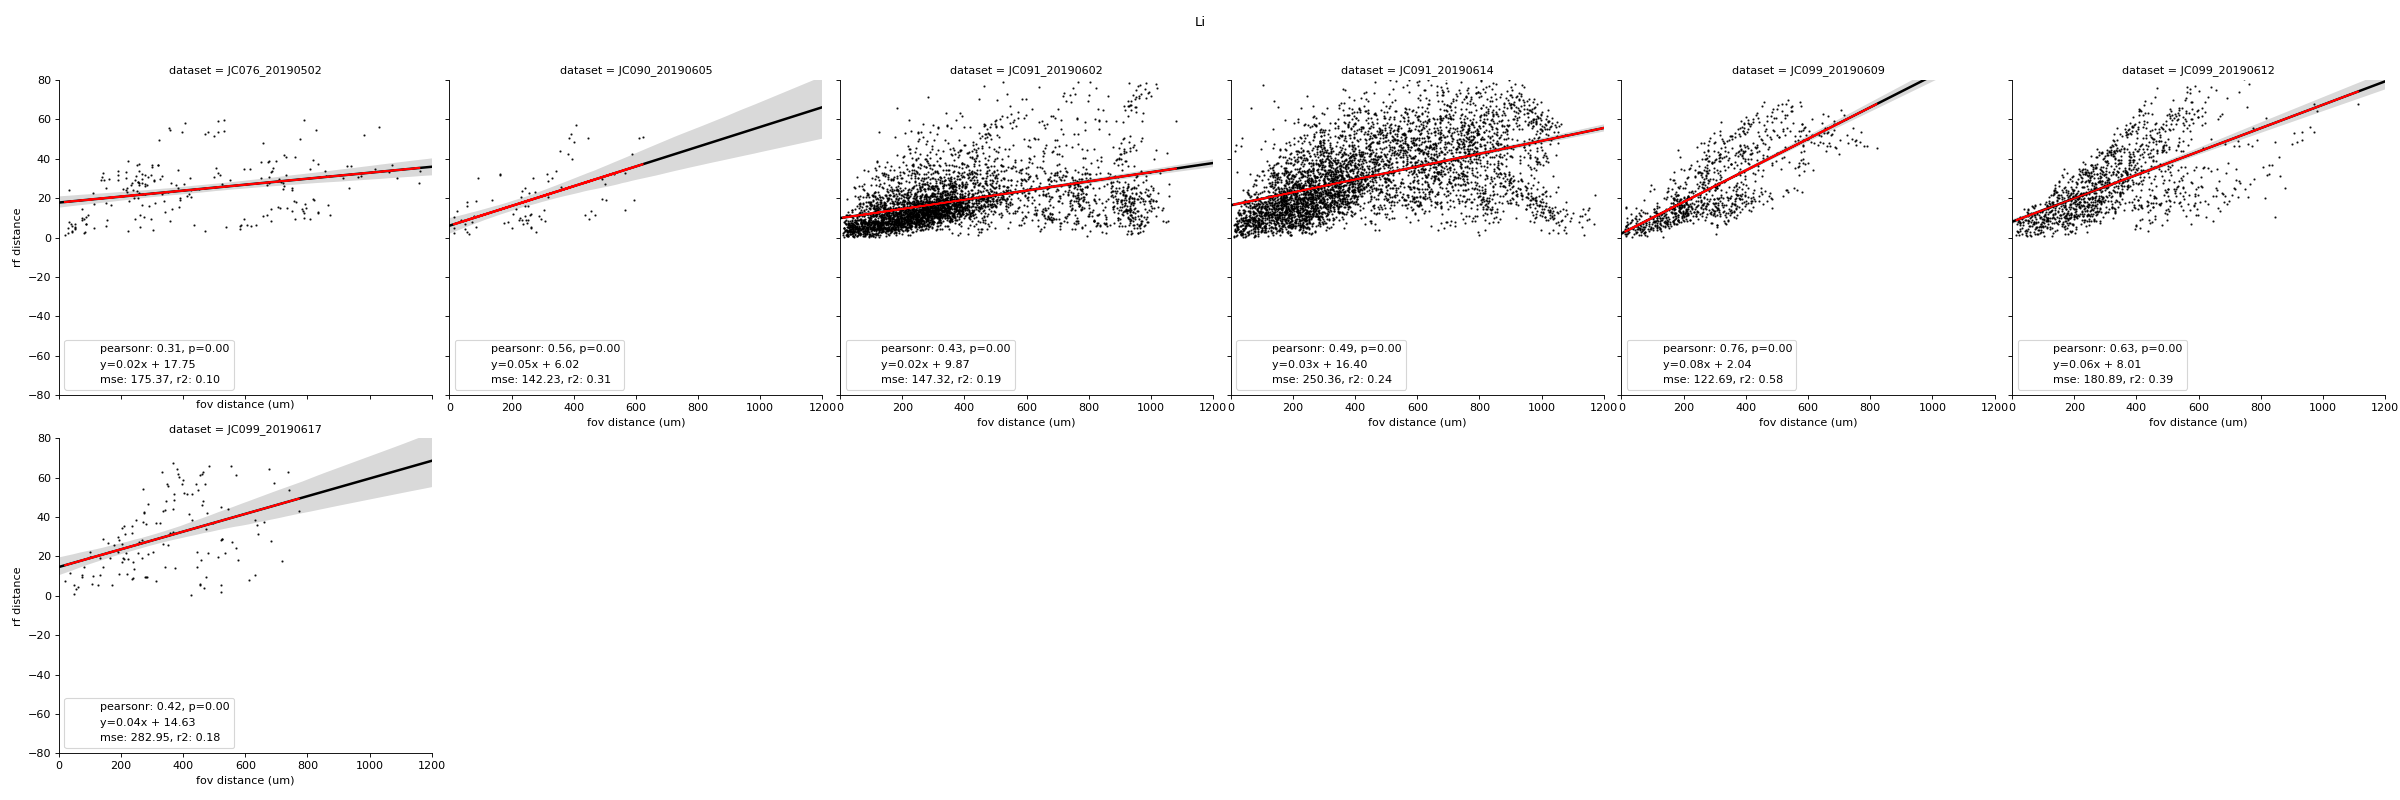

In [84]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200


# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

R2     RMSE         dataset intercept       slope visual_area
0  0.291849   4.5666  JC076_20190420   3.49435   0.0133151          V1
1  0.110722  6.13418  JC076_20190501   6.32593  0.00917705          V1
2  0.317121  3.67584  JC083_20190507   3.21438   0.0141987          V1
3  0.177895  5.95603  JC083_20190510     5.859   0.0142868          V1
4   0.39773  3.88048  JC083_20190511   2.64958   0.0186305          V1

In [96]:
del reginfo

In [85]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [86]:
pwstats.head()

R2     RMSE animalid                       dataset            fov  \
0  0.0953611  13.2428    JC076  JC076_20190502_FOV1_zoom2p0x  FOV1_zoom2p0x   
1    0.31371  11.9261    JC090  JC090_20190605_FOV1_zoom2p0x  FOV1_zoom2p0x   
2   0.186778  12.1375    JC091  JC091_20190602_FOV1_zoom2p0x  FOV1_zoom2p0x   
3   0.243542  15.8227    JC091  JC091_20190614_FOV1_zoom2p0x  FOV1_zoom2p0x   
4   0.584282  11.0767    JC099  JC099_20190609_FOV1_zoom2p0x  FOV1_zoom2p0x   

  intercept   session      slope visual_area  
0   17.7525  20190502  0.0151595          Li  
1   6.01845  20190605  0.0501515          Li  
2   9.86805  20190602  0.0233078          Li  
3   16.3973  20190614  0.0326908          Li  
4   2.04233  20190609  0.0800883          Li

<IPython.core.display.Javascript object>


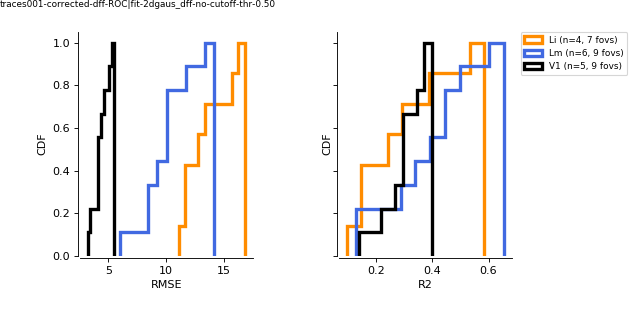

In [87]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


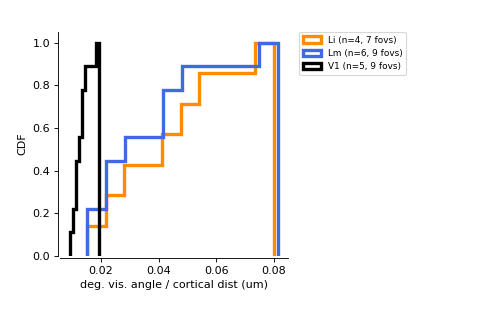

In [88]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


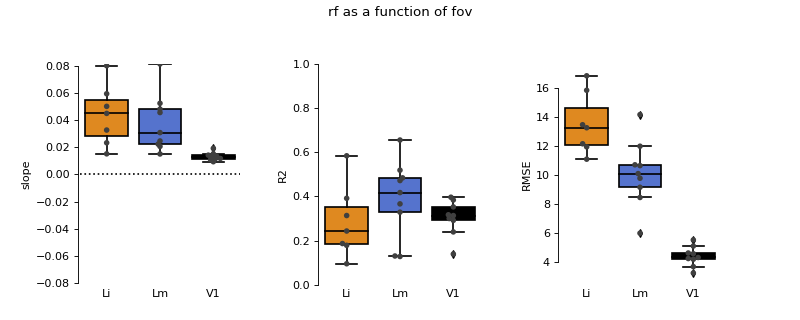

In [89]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

<IPython.core.display.Javascript object>


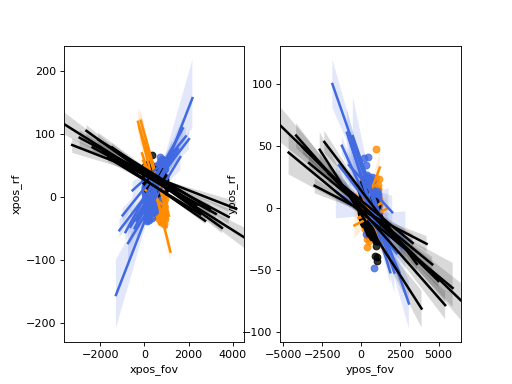

In [90]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [199]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    S = util.Session(animalid, session, fov)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC076|20190502] No experiment exists for: gratings
Stimuli presented at coords: (-5, 8)
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: com

... Getting screen info
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC080|20190506] No experiment exists for: gratings
Stimuli presented at coords: (15, 8)
[JC080] 20190602 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC080|20190602] No experiment exists for: blobs
[JC080|20190602] No experiment exists for: gratings
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC080|20190603|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings


... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (25, 5)
[JC097] 20190615 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC097|20190616|FOV1_zoom2p0x] creating grati

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

r2    sigma_x    sigma_y     theta         x0         y0   cell  \
0    0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018    0.0   
1    0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950    2.0   
2    0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272    5.0   
3    0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018    9.0   
4    0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   11.0   
5    0.749326  24.060205  17.826767 -0.540785  21.079350 -12.622418   12.0   
6    0.855683  30.551514  22.742899 -0.194002  24.359459 -15.700910   17.0   
7    0.696656  27.990076  23.843953  0.069130  25.972457 -13.935280   18.0   
8    0.768487  21.792108  20.778926  0.133244  24.595777 -15.828255   19.0   
9    0.647991  19.231749  23.597969  7.482864  24.647061 -14.644582   20.0   
10   0.664964  28.485420  23.327092 -0.165733  22.522499 -13.689643   21.0   
11   0.697408  37.220701  20.067509 -0.538142  25.617105 -14.165844   23.0   
12   0.830778  28.052161  22.851207  0.019171  23.959988 -18.060165   25.0   
13   0.659888  24.684523  22.871740 -0.110131  25.477272 -14.224848   26.0   
14   0.706372  32.309309  21.921249 -3.626894  24.790675 -15.134649   27.0   
15   0.771317   6.238730   6.857521  2.065690  19.994226 -19.770466   29.0   
16   0.528987  13.406842  11.629828 -2.447291  27.486044 -15.949036   30.0   
17   0.838610  18.920871  15.368178 -6.821364  25.340041 -17.589140   33.0   
18   0.758682  25.043465  28.017584  0.173640  26.432311 -20.467824   35.0   
19   0.842691  17.751149  33.932036  0.535572  30.602510 -26.987631   36.0   
20   0.623137  39.765831  24.771200 -0.669511  22.286065 -18.509528   41.0   
21   0.618670  35.668650  19.654706 -0.137295  20.236856 -13.920210   43.0   
22   0.580811  15.462046  12.018522  1.919947  21.389652 -17.079508   46.0   
23   0.802064  27.752021  20.591647 -0.668535  20.685405 -13.793877   51.0   
24   0.871361  14.736783  11.827486 -0.605707  20.827247 -19.105224   55.0   
25   0.922144  17.177681  26.224431  0.493811  21.744589 -22.958313   56.0   
26   0.871618  16.521106  23.569554  0.764062  22.413474 -18.922926   57.0   
27   0.891020  14.663139  17.637268  1.201600  24.708676 -18.084358   61.0   
28   0.686160  21.183891  16.435022 -0.022699  20.866747 -21.480730   63.0   
29   0.844889  22.705430  32.684764  0.442448  23.979186 -21.983852   65.0   
..        ...        ...        ...       ...        ...        ...    ...   
81   0.721882  20.436226  27.460882 -0.427208  11.284117 -23.986294  171.0   
82   0.635870  25.878303  24.444987 -0.434986  10.510104 -20.072448  174.0   
83   0.813350  22.483890  18.742877  0.397909  11.166434 -18.448552  175.0   
84   0.865164  26.305847  31.387653  0.166666  11.483976 -18.466111  177.0   
85   0.849957  18.340392  30.809925  0.294362  15.497146 -21.477660  179.0   
86   0.693269  26.096302  35.645822  0.755536  16.707170 -20.983488  184.0   
87   0.781412  27.342184  39.406041  0.147644  12.491562 -30.599855  188.0   
88   0.582609  20.290799  24.464417 -0.417452   9.750868 -24.421227  189.0   
89   0.782352  20.881153  25.918258  0.259672  12.556678 -18.171527  190.0   
90   0.835715  14.808048  10.128542  0.177550  14.062034 -13.210156  191.0   
91   0.794471  18.984261  22.412270  0.314406  14.864463 -15.403845  193.0   
92   0.562086  32.455780  21.475909  0.154162  23.113591 -11.583298  194.0   
93   0.813154  27.714355  20.883445 -0.044016  16.923544  -9.058432  203.0   
94   0.606997  29.982173  21.429867  2.886234  13.142431 -11.571851  205.0   
95   0.782076  18.206397  14.606948 -3.506632  14.061718 -10.883947  210.0   
96   0.620140  22.385888  14.165443 -0.340382  14.972889 -10.682200  212.0   
97   0.530217  27.988678  21.714117  0.250591  15.421748 -13.415667  215.0   
98   0.750720  32.446550  29.802162 -0.214508  15.885883 -13.517998  216.0   
99   0.524750  32.493424  14.750089 -0.098812   7.807519  -8.524383  223.0   
100  0.700816  24.475980  21.8589

In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


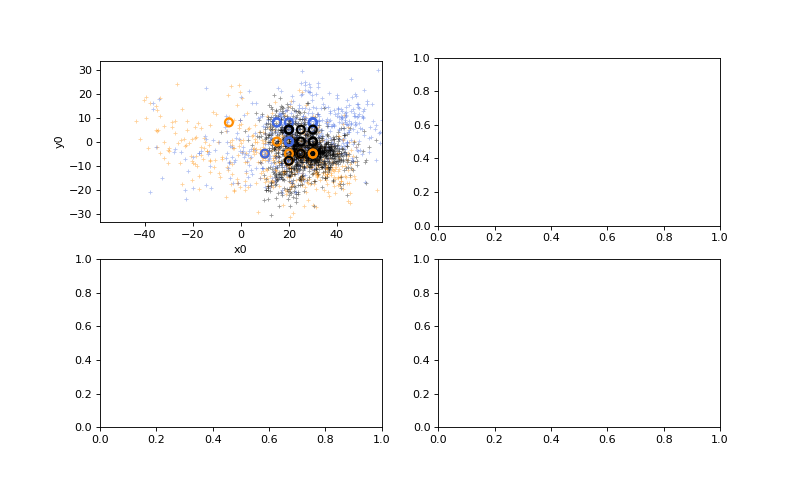

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]